In [17]:
## load useful libraries
suppressWarnings(suppressPackageStartupMessages(library(rhdf5)))
suppressWarnings(suppressPackageStartupMessages(library(qvalue)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(ggbeeswarm)))
suppressWarnings(suppressPackageStartupMessages(library(scater)))
suppressWarnings(suppressPackageStartupMessages(library(SingleCellExperiment)))
suppressWarnings(suppressPackageStartupMessages(library(edgeR)))
# suppressWarnings(suppressPackageStartupMessages(library(scQTLs)))
suppressWarnings(suppressPackageStartupMessages(library(limma)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(RColorBrewer)))

In [2]:
GetResults <- function(results.folder) {
  observed.features <- 0
  results <- NULL
  files.to.read <- list.files(results.folder,pattern = "qtl_results.*h5", full.names = T)
  for ( i in files.to.read ) {
    tmp <- h5dump(file = i)
    if ( length(tmp) > 0 ) {
      for ( j in names(tmp) ) { tmp[[j]][["feature"]] <- j }
      observed.features = observed.features + length(tmp)
      df <- bind_rows(tmp)
      if ( nrow(df) > 0 ) { 
          df <- df[,!(colnames(df) %in% c("group","name", "otype", "dclass",  "dim"))]
          results = rbind(results,df) }
    }
  }
  H5close()
  results <- results[order(results$p_value ),]
  snp_info = as_data_frame(do.call("rbind", lapply(strsplit(results$snp_id, "_"), function(x) t(as.data.frame(x)))))
  colnames(snp_info) = c("chrom","pos","ref_allele","alt_allele")
  results = cbind(results,snp_info)
  results$chrom = as.integer(results$chrom)
  results$pos = as.integer(results$pos)
  results
}

In [39]:
GetTopResults <- function(results.folder, multiple.testing.global = "ST") {
  observed.features <- 0
  results <- NULL
  files.to.read <- list.files(results.folder,pattern = "qtl_results.*h5", full.names = T)
 # print(files.to.read)
    for ( i in files.to.read ) {
    tmp <- h5dump(file = i)
    if ( length(tmp) > 0 ) {
      for ( j in names(tmp) ) { tmp[[j]][["feature"]] <- j }
      observed.features = observed.features + length(tmp)
      df <- bind_rows(tmp)
 #   print (head(df))
      if ( nrow(df) > 0 ) { 
          df <- df[,!(colnames(df) %in% c("group","name", "otype", "dclass",  "dim"))]
          results = rbind(results,df) }
    }
  }
  H5close()
  if ( length(which(is.na(results$empirical_feature_p_value))) != 0 ) {
    results <- results[-which(is.na(results$empirical_feature_p_value)),]
  }
  ##Multiple testing
  if ( multiple.testing.global == "ST" ) {
    results <- results[order(results$empirical_feature_p_value, results$p_value ),]
    #get best SNP per feature
    results <- results[-which(duplicated(results$feature)),]
    
    results["global_corr_p_value"] <- qvalue(results$empirical_feature_p_value)$qvalues
      
  } else if ( multiple.testing.global == "BF" ) {
    results["global_corr_p_value"] <- results$empirical_feature_p_value*observed.features
    results$global_corr_p_value[results$global_corr_p_value > 1] <- 1
  }
  results <- results[order(results$global_corr_p_value, results$empirical_feature_p_value, results$p_value ),]
  snp_info = as_data_frame(do.call("rbind", lapply(strsplit(results$snp_id, "_"), function(x) t(as.data.frame(x)))))
  colnames(snp_info) = c("chrom","pos","ref_allele","alt_allele")
  results = cbind(results,snp_info)
  results$chrom = as.integer(results$chrom)
  results$pos = as.integer(results$pos)
  results
}

In [40]:
leads.ips = GetTopResults(mean.ips.dir)
leads.mesendo = GetTopResults(mean.mesendo.dir)
leads.defendo = GetTopResults(mean.defendo.dir)

In [41]:
leads = leads.ips
c(nrow(leads),nrow(leads[leads$global_corr_p_value < 0.1,]))

[1] 10788  1721

In [42]:
leads = leads.mesendo
c(nrow(leads),nrow(leads[leads$global_corr_p_value < 0.1,]))

[1] 10788   766

In [43]:
leads = leads.defendo
c(nrow(leads),nrow(leads[leads$global_corr_p_value < 0.1,]))

[1] 10788  1649

In [36]:
mean.ips.dir = "/nfs/leia/research/stegle/acuomo/singlecell_endodiff/20181003/mean_ips/"
top_qtls_filename = paste0(mean.ips.dir,"top_qtl_results_all.txt")
top_qtls = read.csv(top_qtls_filename, sep = "\t")
top_qtls$q_value = qvalue(top_qtls$empirical_feature_p_value)$qvalues
# top_qtls$q_value = qvalue(p = top_qtls$p_value, lambda = 0)$qvalues
# hist(top_qtls$p_value)
dim(top_qtls)
dim(top_qtls[top_qtls$q_value < 0.1,])

[1] 10924    23

[1] 1749   23

In [37]:
mean.mesendo.dir = "/nfs/leia/research/stegle/acuomo/singlecell_endodiff/20181003/mean_mesendo/"
top_qtls_filename = paste0(mean.mesendo.dir,"top_qtl_results_all.txt")
top_qtls = read.csv(top_qtls_filename, sep = "\t")
top_qtls$q_value = qvalue(top_qtls$empirical_feature_p_value)$qvalues
dim(top_qtls)
dim(top_qtls[top_qtls$q_value < 0.1,])

[1] 10924    23

[1] 770  23

In [38]:
mean.defendo.dir = "/nfs/leia/research/stegle/acuomo/singlecell_endodiff/20181003/mean_defendo/"
top_qtls_filename = paste0(mean.defendo.dir,"top_qtl_results_all.txt")
top_qtls = read.csv(top_qtls_filename, sep = "\t")
top_qtls$q_value = qvalue(top_qtls$empirical_feature_p_value)$qvalues
dim(top_qtls)
dim(top_qtls[top_qtls$q_value < 0.1,])

[1] 10924    23

[1] 1670   23

In [44]:
mean.ips_morethan10cells.dir = "/nfs/leia/research/stegle/acuomo/singlecell_endodiff/20181003/mean_ips_morethan10cells/"
top_qtls_filename = paste0(mean.ips_morethan10cells.dir,"top_qtl_results_all.txt")
top_qtls = read.csv(top_qtls_filename, sep = "\t")
top_qtls$q_value = qvalue(top_qtls$empirical_feature_p_value)$qvalues
dim(top_qtls)
dim(top_qtls[top_qtls$q_value < 0.1,])

[1] 10924    23

[1] 1841   23

In [46]:
mean.mesendo_morethan10cells.dir = "/nfs/leia/research/stegle/acuomo/singlecell_endodiff/20181003/mean_mesendo_morethan10cells/"
top_qtls_filename = paste0(mean.mesendo_morethan10cells.dir,"top_qtl_results_all.txt")
top_qtls = read.csv(top_qtls_filename, sep = "\t")
top_qtls$q_value = qvalue(top_qtls$empirical_feature_p_value)$qvalues
dim(top_qtls)
dim(top_qtls[top_qtls$q_value < 0.1,])

[1] 10924    23

[1] 1888   23

In [48]:
mean.defendo_morethan10cells.dir = "/nfs/leia/research/stegle/acuomo/singlecell_endodiff/20181003/mean_defendo_morethan10cells/"
top_qtls_filename = paste0(mean.defendo_morethan10cells.dir,"top_qtl_results_all.txt")
top_qtls = read.csv(top_qtls_filename, sep = "\t")
top_qtls$q_value = qvalue(top_qtls$empirical_feature_p_value)$qvalues
dim(top_qtls)
dim(top_qtls[top_qtls$q_value < 0.1,])

[1] 10924    23

[1] 2426   23

In [58]:
# leads.ips_morethan10cells = GetTopResults(mean.ips_morethan10cells.dir)
leads = leads.ips_morethan10cells
c(nrow(leads),nrow(leads[leads$global_corr_p_value < 0.1,]))
ips.sign = leads[leads$global_corr_p_value < 0.1,]

[1] 10788  1813

In [50]:
# leads.mesendo_morethan10cells = GetTopResults(mean.mesendo_morethan10cells.dir)
leads = leads.mesendo_morethan10cells
c(nrow(leads),nrow(leads[leads$global_corr_p_value < 0.1,]))
mesendo.sign = leads[leads$global_corr_p_value < 0.1,]

[1] 10788  1864

In [52]:
mesendo.sign[grep("SPP1",mesendo.sign$feature),]

beta       beta_se   empirical_feature_p_value p_value     
4100460 -0.4925519 0.1184807 0.005712788               3.221266e-05
        snp_id         feature              global_corr_p_value chrom pos     
4100460 4_88896797_T_G ENSG00000118785_SPP1 0.03866066          4     88896797
        ref_allele alt_allele
4100460 T          G

In [56]:
# leads.defendo_morethan10cells = GetTopResults(mean.defendo_morethan10cells.dir)
# leads = leads.defendo_morethan10cells
# c(nrow(leads),nrow(leads[leads$global_corr_p_value < 0.1,]))
defendo.sign = leads[leads$global_corr_p_value < 0.1,]

In [57]:
defendo.sign[grep("CNTNAP2",defendo.sign$feature),]

beta       beta_se    empirical_feature_p_value p_value     
4722284 -0.3799801 0.07417263 0.000425373               3.008473e-07
        snp_id          feature                 global_corr_p_value chrom
4722284 7_148086952_C_T ENSG00000174469_CNTNAP2 0.004224382         7    
        pos       ref_allele alt_allele
4722284 148086952 C          T

In [500]:
### Compare variance results with mean results

In [501]:
res.var.ips.leads <- GetResults("/nfs/leia/research/stegle/acuomo/variances/variance_ips_leads/") 

In [502]:
res.var.ips.leads$qvalue <- qvalue(res.var.ips.leads$p_value)$qvalues
dim(res.var.ips.leads)
# head(res.var.ips.leads)

[1] 1803   11

In [503]:
## iPSC (day0)
leads.ips = read.csv("/nfs/leia/research/stegle/acuomo/mean/day0/all_expts/leads.csv", row.names = 1)
leads.ips.sign = leads.ips[leads.ips$global_corr_p_value < 0.1,]

In [504]:
dim(leads.ips.sign)
# head(leads.ips.sign)

[1] 1833   21

In [505]:
df.ips <- inner_join(leads.ips.sign, res.var.ips.leads, by = c("snp_id","feature"), suffix = c(".mean",".var"))
head(df.ips[,c("feature","snp_id","global_corr_p_value","p_value.mean","p_value.var","beta.mean","beta.var","qvalue")])

feature                snp_id          global_corr_p_value p_value.mean
1 ENSG00000164587_RPS14  5_149826526_C_T 2.880363e-30        3.851118e-36
2 ENSG00000134809_TIMM10 11_57283988_C_T 8.853960e-23        3.147553e-30
3 ENSG00000197728_RPS26  12_56401085_G_A 8.853960e-23        9.762508e-30
4 ENSG00000214087_ARL16  17_79634162_T_G 9.364347e-23        3.835702e-33
5 ENSG00000198563_DDX39B 6_31486901_T_C  1.096676e-22        7.269794e-39
6 ENSG00000163682_RPL9   4_39446549_G_A  1.260613e-22        2.553619e-46
  p_value.var  beta.mean  beta.var    qvalue      
1 7.427764e-01 -1.0048674  0.00532628 3.014110e-01
2 4.608194e-02 -0.9881017  0.12065993 3.749514e-02
3 1.062358e-03 -0.8408477  0.19061601 2.207092e-03
4 1.759544e-11 -1.0706501  0.35396976 3.321307e-10
5 4.246774e-01 -1.1430440 -0.03036424 1.996915e-01
6 1.425362e-01 -1.4578537  0.02175124 8.850349e-02

[1] 0.3721234

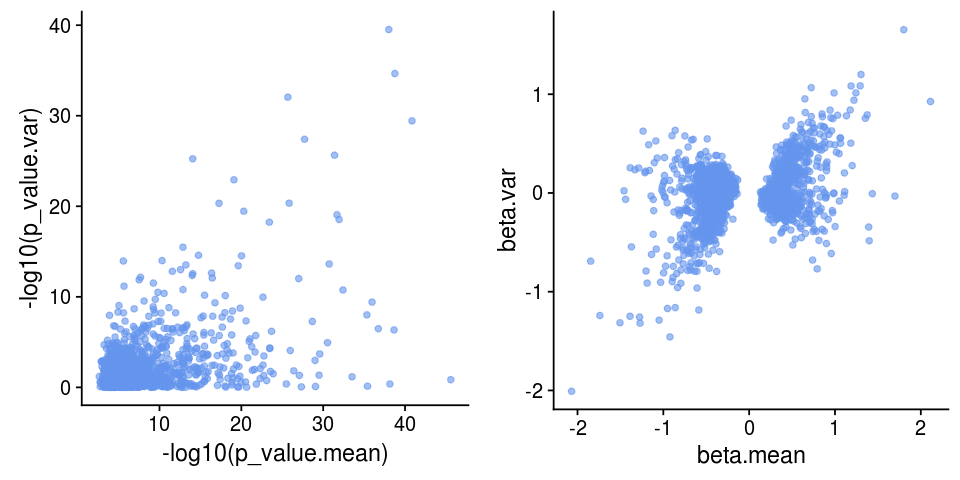

In [506]:
p1 <- ggplot(df.ips, aes(x = -log10(p_value.mean), y = -log10(p_value.var))) + 
    geom_point(alpha = 0.6, col = "cornflowerblue")
p2 <- ggplot(df.ips, aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "cornflowerblue")
options(repr.plot.width = 8, repr.plot.height = 4)
cor(df.ips$beta.mean, df.ips$beta.var)
plot_grid(p1, p2, ncol = 2)

In [507]:
res.var.me.leads <- GetResults("/nfs/leia/research/stegle/acuomo/variances/variance_mesendo_leads/") 

In [508]:
res.var.me.leads$qvalue <- qvalue(res.var.me.leads$p_value)$qvalues
dim(res.var.me.leads)

[1] 1622   11

In [509]:
## mesendo
leads.mes = read.csv("/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/leads.csv", row.names = 1)
leads.mes.sign = leads.mes[leads.mes$global_corr_p_value < 0.1,]

In [510]:
dim(leads.mes.sign)

[1] 1702   21

In [511]:
df.me <- inner_join(leads.mes.sign, res.var.me.leads, by = c("snp_id","feature"), suffix = c(".mean",".var"))
head(df.me[,c("feature","snp_id","global_corr_p_value","p_value.mean","p_value.var","beta.mean","beta.var","qvalue")])

feature                snp_id         global_corr_p_value p_value.mean
1 ENSG00000233927_RPS28  19_8387207_G_A 7.547212e-32        4.944358e-35
2 ENSG00000163682_RPL9   4_39446549_G_A 5.240275e-30        3.690889e-37
3 ENSG00000142089_IFITM3 11_320394_C_T  3.628888e-28        7.623224e-25
4 ENSG00000226278_PSPHP1 7_55833413_A_C 6.089332e-26        1.547255e-34
5 ENSG00000206503_HLA-A  6_29812578_C_A 2.142262e-23        4.421858e-25
6 ENSG00000130305_NSUN5  7_72717933_C_T 2.142262e-23        2.222372e-23
  p_value.var  beta.mean  beta.var    qvalue      
1 7.375958e-01 -1.3845452  0.01115478 3.386871e-01
2 3.799613e-02 -1.4456919 -0.04196796 4.946159e-02
3 4.962388e-12 -1.1192718  0.47728536 2.055026e-10
4 2.235662e-28  1.7971633  1.54168742 7.406666e-26
5 9.658262e-14 -1.7892350 -1.13609286 4.922687e-12
6 6.970353e-04 -0.9147762 -0.30474192 3.038490e-03

[1] 0.477316

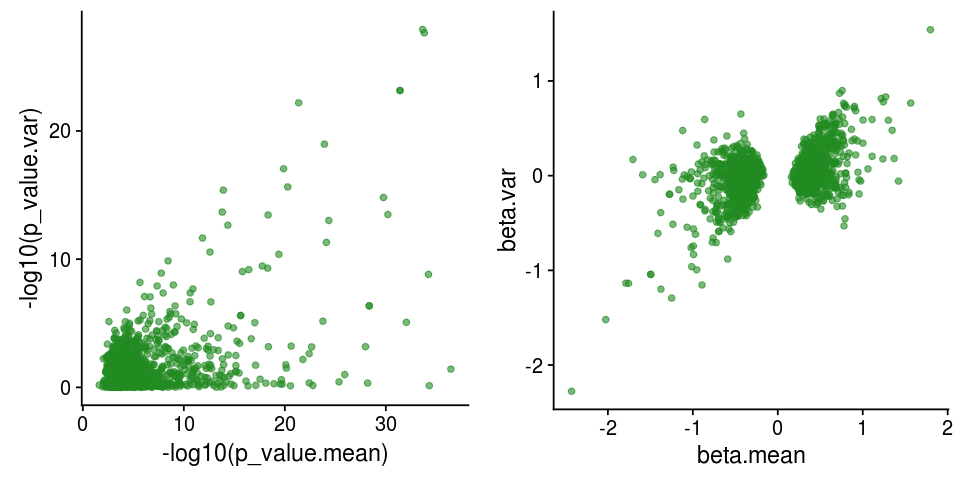

In [512]:
p1 <- ggplot(df.me, aes(x = -log10(p_value.mean), y = -log10(p_value.var))) + 
    geom_point(alpha = 0.6, col = "forestgreen")
p2 <- ggplot(df.me, aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "forestgreen")
options(repr.plot.width = 8, repr.plot.height = 4)
cor(df.me$beta.mean, df.me$beta.var)
plot_grid(p1, p2, ncol = 2)

In [513]:
res.var.de.leads <- GetResults("/nfs/leia/research/stegle/acuomo/variances/variance_defendo_leads/") 

In [514]:
res.var.de.leads$qvalue <- qvalue(res.var.de.leads$p_value)$qvalues
dim(res.var.de.leads)

[1] 1317   11

In [515]:
## defendo
leads.defendo = read.csv("/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20/leads.csv", row.names = 1)
leads.defendo.sign = leads.defendo[leads.defendo$global_corr_p_value < 0.1,]

In [516]:
dim(leads.defendo.sign)

[1] 1342   21

In [517]:
df.de <- inner_join(leads.defendo.sign, res.var.de.leads, by = c("snp_id","feature"), suffix = c(".mean",".var"))
head(df.de[,c("feature","snp_id","global_corr_p_value","p_value.mean","p_value.var","beta.mean","beta.var","qvalue")])

feature                snp_id          global_corr_p_value p_value.mean
1 ENSG00000076924_XAB2   19_7710920_G_A  5.834040e-43        2.917519e-29
2 ENSG00000226278_PSPHP1 7_55802063_T_C  2.998245e-31        3.262402e-32
3 ENSG00000132507_EIF5A  17_7207964_A_C  1.045074e-28        2.607221e-23
4 ENSG00000168653_NDUFS5 1_39465139_A_C  1.979745e-28        2.352239e-25
5 ENSG00000134809_TIMM10 11_57283988_C_T 6.671257e-25        5.732365e-21
6 ENSG00000152208_GRID2  4_93343395_C_T  8.571374e-23        2.175315e-21
  p_value.var  beta.mean  beta.var    qvalue      
1 5.841488e-20  1.2022830  1.08455367 2.555830e-18
2 1.434181e-29  1.7099543  1.60315965 5.019985e-27
3 2.782737e-01 -0.9470534 -0.06665804 1.053136e-01
4 2.472442e-02 -0.9122687  0.08992847 1.707085e-02
5 1.904596e-13 -1.0173650  0.48694525 2.666622e-12
6 6.384896e-14  1.0996537  0.88410016 9.716828e-13

[1] 0.4577111

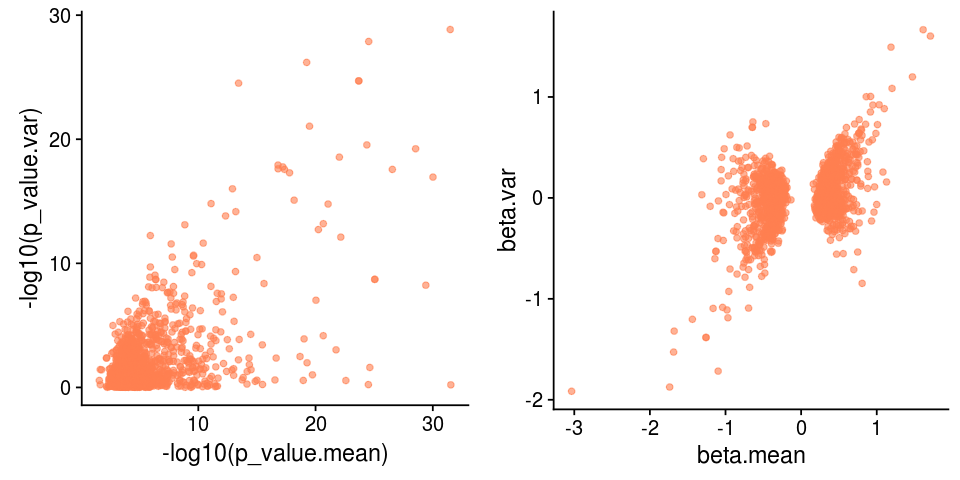

In [518]:
p1 <- ggplot(df.de, aes(x = -log10(p_value.mean), y = -log10(p_value.var))) + 
    geom_point(alpha = 0.6, col = "coral")
p2 <- ggplot(df.de, aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "coral")
options(repr.plot.width = 8, repr.plot.height = 4)
cor(df.de$beta.mean, df.de$beta.var)
plot_grid(p1, p2, ncol = 2)

In [519]:
# remove non - significant QTLs for variance

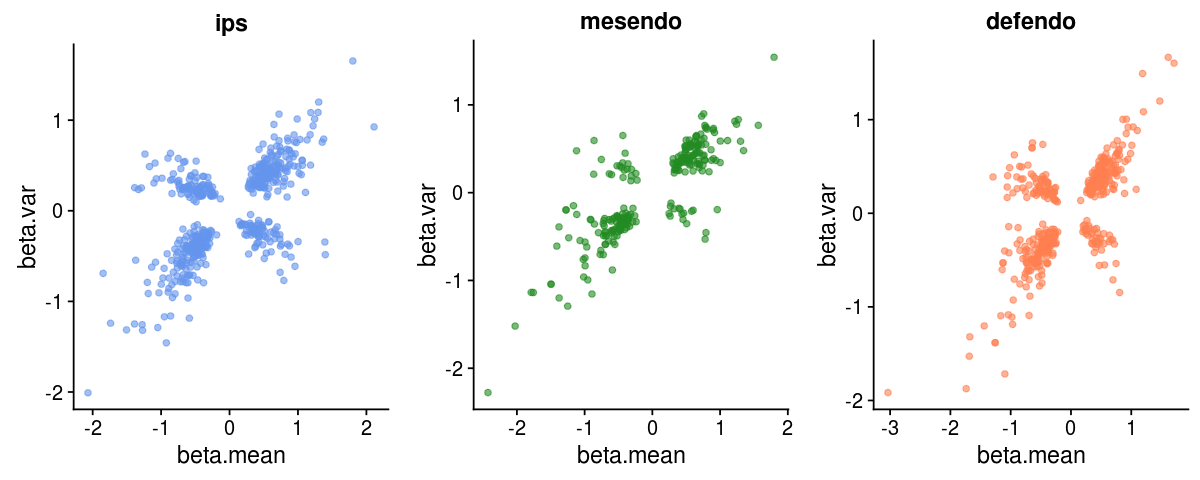

In [520]:
p1 <- ggplot(df.ips[df.ips$qvalue < 0.01,], aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "cornflowerblue") + ggtitle("ips")
p2 <- ggplot(df.me[df.me$qvalue < 0.01,], aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "forestgreen") + ggtitle("mesendo")
p3 <- ggplot(df.de[df.de$qvalue < 0.01,], aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "coral") + ggtitle("defendo")
options(repr.plot.width = 10, repr.plot.height = 4)
plot_grid(p1, p2, p3, ncol = 3)

In [521]:
## colour by expression

In [3]:
sce.file = "/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds"
sce = readRDS(sce.file)

In [8]:
sce.hvg = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.slalom.is_intop2000hvg.rds")
sce$pseudo = sce.hvg$pseudo

In [10]:
saveRDS(sce, sce.file)

In [5]:
rownames(sce)[grep("RPS10",rownames(sce))]

[1] "ENSG00000048544_MRPS10"      "ENSG00000124614_RPS10"      
[3] "ENSG00000270800_RPS10-NUDT3"

In [66]:
sce.hvg = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.slalom.is_intop2000hvg.rds")
sce$stage = sce.hvg$stage

In [67]:
sce.ips = sce[,sce$stage == "ips"]
sce.mesendo = sce[,sce$stage == "mesendo"]
sce.defendo = sce[,sce$stage == "defendo"]

In [522]:
expr.ips <- logcounts(sce.ips)[rownames(sce.ips) %in% df.ips$feature,]
df.exprs.ips <- data.frame(feature = rownames(expr.ips), avg_expr = rowMeans(expr.ips))
df.ips.expr <- inner_join(df.ips, df.exprs.ips, by = "feature")

expr.me =  logcounts(sce.mesendo)[rownames(sce.mesendo) %in% df.me$feature,]
df.exprs.me <- data.frame(feature = rownames(expr.me), avg_expr = rowMeans(expr.me))
df.me.expr <- inner_join(df.me, df.exprs.me, by = "feature")

expr.de =  logcounts(sce.defendo)[rownames(sce.defendo) %in% df.de$feature,]
df.exprs.de <- data.frame(feature = rownames(expr.de), avg_expr = rowMeans(expr.de))
df.de.expr <- inner_join(df.de, df.exprs.de, by = "feature")

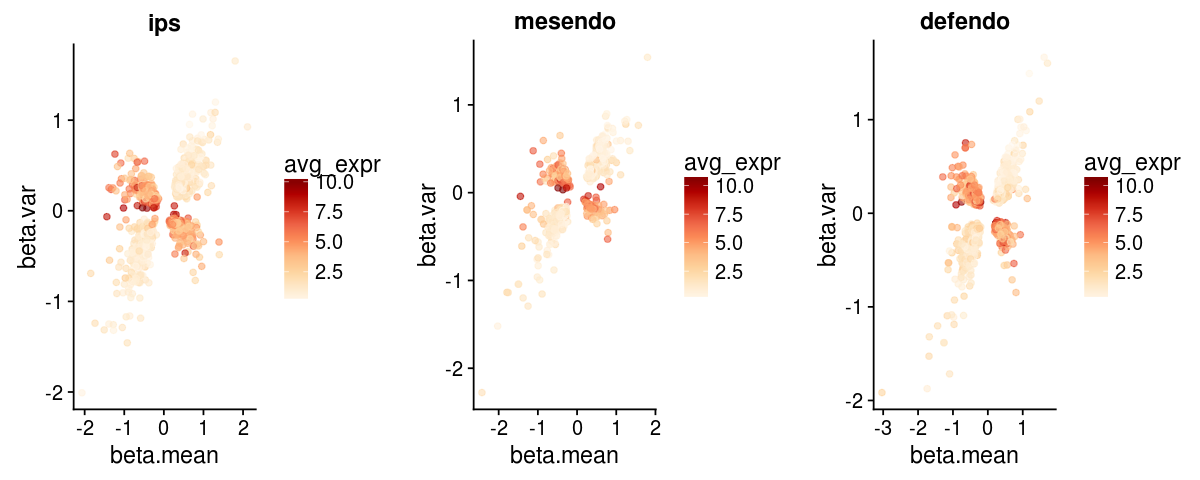

In [468]:
p1 <- ggplot(df.ips.expr[df.ips.expr$qvalue < 0.05,], 
             aes(x = beta.mean, y = beta.var, colour = avg_expr)) + 
    geom_point(alpha = 0.6) + scale_colour_gradientn(colors = brewer.pal("OrRd",n = 9)) +  ggtitle("ips")
p2 <- ggplot(df.me.expr[df.me.expr$qvalue < 0.05,], 
             aes(x = beta.mean, y = beta.var, colour = avg_expr)) + 
    geom_point(alpha = 0.6) + scale_colour_gradientn(colors = brewer.pal("OrRd",n = 9)) + ggtitle("mesendo")
p3 <- ggplot(df.de.expr[df.de.expr$qvalue < 0.05,], 
             aes(x = beta.mean, y = beta.var, colour = avg_expr)) + 
    geom_point(alpha = 0.6) + scale_colour_gradientn(colors = brewer.pal("OrRd",n = 9)) + ggtitle("defendo")
options(repr.plot.width = 10, repr.plot.height = 4)
plot_grid(p1, p2, p3, ncol = 3)

In [ ]:
m.ips <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/mean/variance/ips_pheno.txt", sep = "\t", row.names = 1)
# head(m.ips)                

In [271]:
v.ips <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/variance/variance/ips_pheno.txt", sep = "\t", row.names = 1)
# head(v.ips)                

In [311]:
df.ips.genes = data.frame(meanlog = rowMeans(logcounts(sce.ips)),
                         varlog = apply(logcounts(sce.ips),1,var),
                         genes = rownames(sce.ips))
head(df.ips.genes)

meanlog   varlog    genes                   
ENSG00000000003_TSPAN6   5.6612948 0.7485352 ENSG00000000003_TSPAN6  
ENSG00000000419_DPM1     5.8787894 1.2713185 ENSG00000000419_DPM1    
ENSG00000000457_SCYL3    0.8104053 1.0803857 ENSG00000000457_SCYL3   
ENSG00000000460_C1orf112 3.1627028 1.8028704 ENSG00000000460_C1orf112
ENSG00000001036_FUCA2    4.3762595 1.0536505 ENSG00000001036_FUCA2   
ENSG00000001084_GCLC     2.0716895 2.1813389 ENSG00000001084_GCLC

In [317]:
gene = 'ENSG00000000003_TSPAN6'

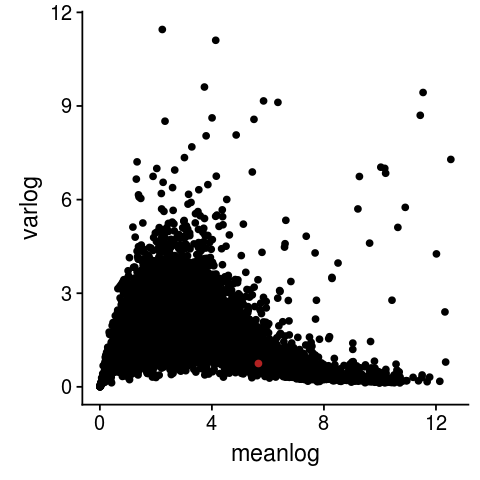

In [319]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(df.ips.genes, aes(x = meanlog, y = varlog)) + geom_point() + 
    geom_point(data = df.ips.genes[gene,], aes(x = meanlog, y = varlog), col = "firebrick")

In [320]:
genos = read.table("/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/selectionAnna_July3rd.dosages.txt", header = T, row.names = 1)

In [356]:
df.ips.expr <- df.ips.expr[order(df.ips.expr$qvalue),]
qtl = df.ips.expr[df.ips.expr$beta.var*df.ips.expr$beta.mean < 0,][5,]

In [357]:
# qtl
snp = qtl$snp_id
gene = qtl$feature
snp
gene
ref = qtl$ref_allele.var
alt = qtl$alt_allele.var

[1] "18_13664222_C_T"

[1] "ENSG00000177150_FAM210A"

In [358]:
#genos
geno = genos[rownames(genos) == snp,]
df1 = as.data.frame(t(rbind(geno,colnames(geno))))
df1[,2] = gsub("\\.","-",df1[,2])
df1[,2] = gsub(".*-","",df1[,2])
colnames(df1) = c("dosages","donor")
df1 <- dplyr::mutate(df1, genotypes = round(as.numeric(dosages)))
df1[df1$genotypes == 0,"alleles"] <- paste0(ref,ref)
df1[df1$genotypes == 1,"alleles"] <- paste0(ref,alt)
df1[df1$genotypes == 2,"alleles"] <- paste0(alt,alt)
# head(df1)

In [359]:
df0 = data.frame(variance = matrix(t(v.ips[gene,])), mean = matrix(t(m.ips[gene,])), donor.expt.day = colnames(v.ips))
df0$donor <- gsub("\\..*","",df0$donor.expt.day)
# head(df0)

In [360]:
df <- inner_join(df1, df0, by = "donor")
# head(df)

In [361]:
col = "cornflowerblue"
p1 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(variance))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(variance), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("variance logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p2 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(mean))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(mean), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("mean logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p3 <- ggplot(df, aes(x = as.numeric(mean), y = as.numeric(variance))) + 
        geom_point(col = col, size = 1, alpha = 0.3) + 
        xlab("mean logcounts") + ylab("variance logcounts") + theme_bw() + ggtitle(gsub(".*_","",gene))
p4 <- ggplot(df.ips.genes, aes(x = meanlog, y = varlog)) + geom_point() + 
    geom_point(data = df.ips.genes[gene,], aes(x = meanlog, y = varlog), col = "firebrick")
options(repr.plot.width = 10, repr.plot.height = 3)

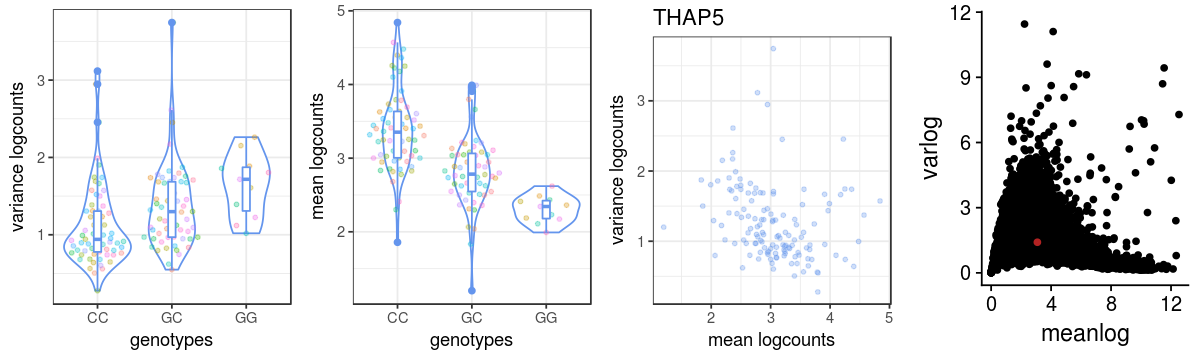

In [327]:
plot_grid(p1, p2, p3, p4, ncol = 4)

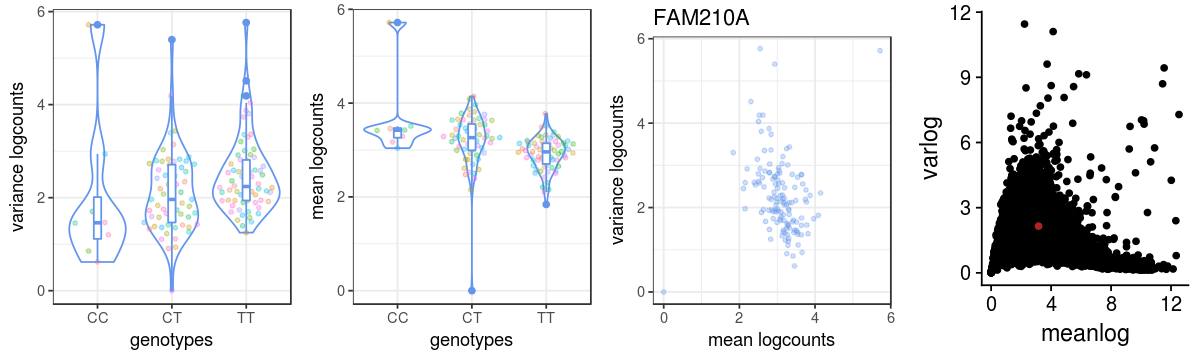

In [362]:
plot_grid(p1, p2, p3, p4, ncol = 4)

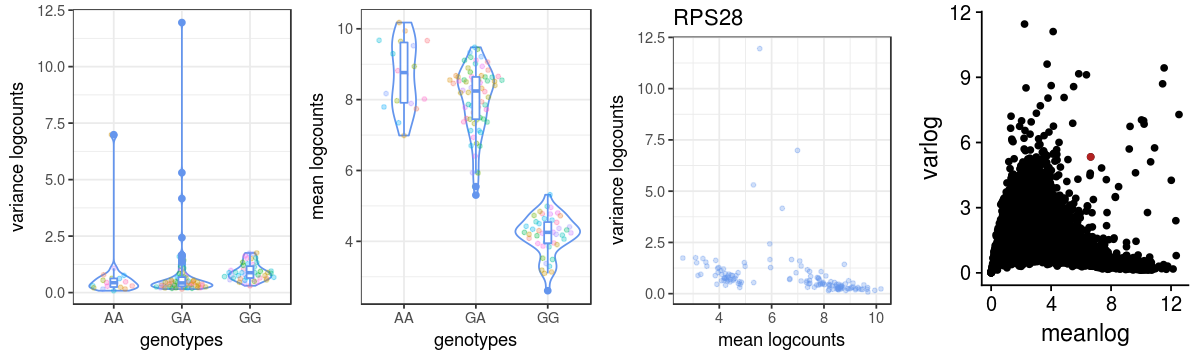

In [355]:
plot_grid(p1, p2, p3, p4, ncol = 4)

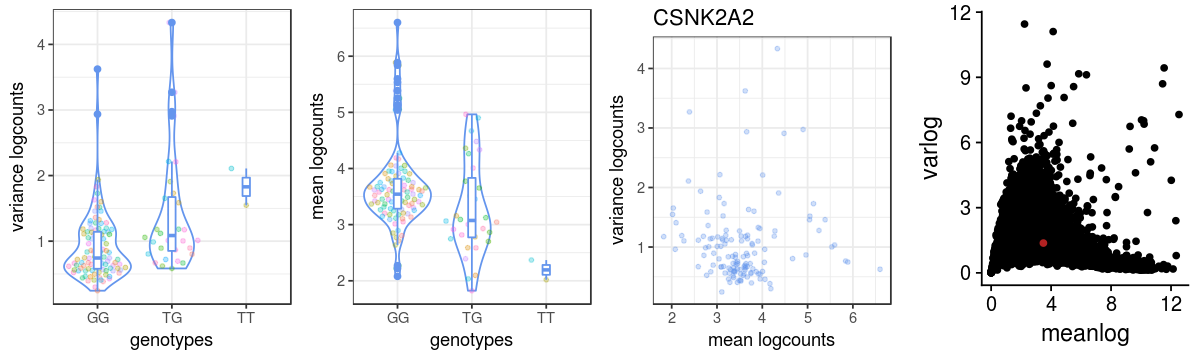

In [348]:
plot_grid(p1, p2, p3, p4, ncol = 4)

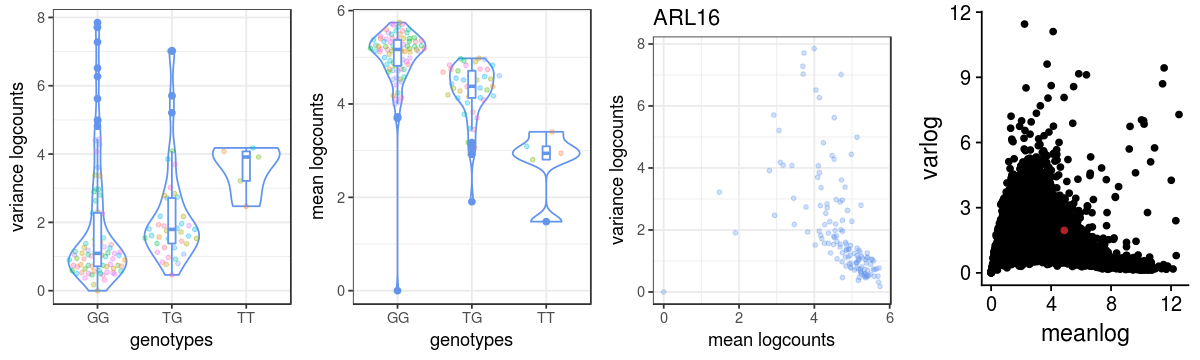

In [341]:
plot_grid(p1, p2, p3, p4, ncol = 4)

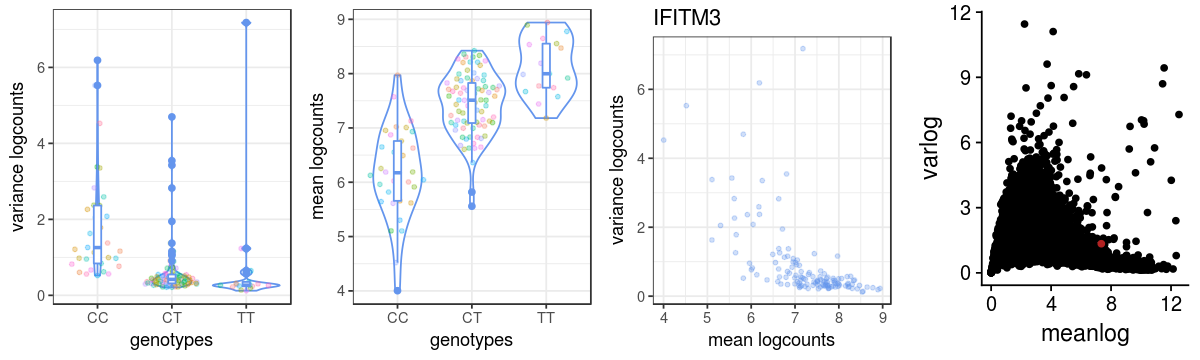

In [334]:
plot_grid(p1, p2, p3, p4, ncol = 4)

In [529]:
df.me.genes = data.frame(meanlog = rowMeans(logcounts(sce.mesendo)),
                         varlog = apply(logcounts(sce.mesendo),1,var),
                         genes = rownames(sce.mesendo))
head(df.me.genes)

meanlog   varlog    genes                   
ENSG00000000003_TSPAN6   5.7597709 0.8427556 ENSG00000000003_TSPAN6  
ENSG00000000419_DPM1     5.9521317 1.2752616 ENSG00000000419_DPM1    
ENSG00000000457_SCYL3    0.8433053 1.2329324 ENSG00000000457_SCYL3   
ENSG00000000460_C1orf112 3.2096822 1.8631385 ENSG00000000460_C1orf112
ENSG00000001036_FUCA2    3.4844346 2.0282591 ENSG00000001036_FUCA2   
ENSG00000001084_GCLC     1.6103229 2.2921719 ENSG00000001084_GCLC

In [531]:
gene = "ENSG00000000003_TSPAN6"

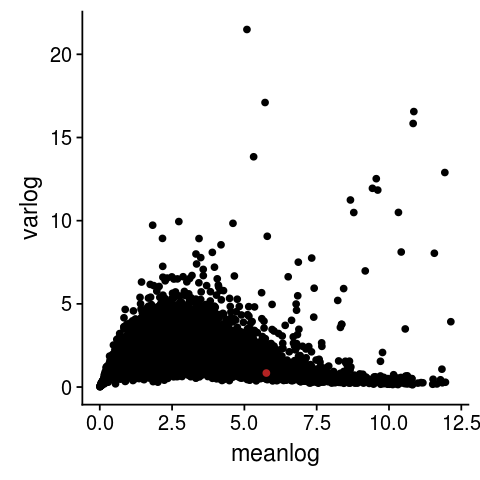

In [532]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(df.me.genes, aes(x = meanlog, y = varlog)) + geom_point() + 
    geom_point(data = df.me.genes[gene,], aes(x = meanlog, y = varlog), col = "firebrick")

In [287]:
m.mesendo <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/mean/variance/mesendo_pheno.txt", sep = "\t", row.names = 1)
# head(m.mesendo)                

In [177]:
v.mesendo <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/variance/variance/mesendo_pheno.txt", sep = "\t", row.names = 1)
# head(v.mesendo)                

In [523]:
df.me.expr <- df.me.expr[order(df.me.expr$qvalue),]
qtl = df.me.expr[df.me.expr$beta.var*df.me.expr$beta.mean < 0,][5,]

In [524]:
# qtl
snp = qtl$snp_id
gene = qtl$feature
snp
gene
ref = qtl$ref_allele.var
alt = qtl$alt_allele.var

[1] "4_68480525_C_T"

[1] "ENSG00000033178_UBA6"

In [525]:
#genos
geno = genos[rownames(genos) == snp,]
df1 = as.data.frame(t(rbind(geno,colnames(geno))))
df1[,2] = gsub("\\.","-",df1[,2])
df1[,2] = gsub(".*-","",df1[,2])
colnames(df1) = c("dosages","donor")
df1 <- dplyr::mutate(df1, genotypes = round(as.numeric(dosages)))
df1[df1$genotypes == 0,"alleles"] <- paste0(ref,ref)
df1[df1$genotypes == 1,"alleles"] <- paste0(ref,alt)
df1[df1$genotypes == 2,"alleles"] <- paste0(alt,alt)
# head(df1)

In [526]:
df0 = data.frame(variance = matrix(t(v.mesendo[gene,])), mean = matrix(t(m.mesendo[gene,])), donor.expt.day = colnames(v.mesendo))
df0$donor <- gsub("\\..*","",df0$donor.expt.day)
# head(df0)

df <- inner_join(df1, df0, by = "donor")

In [533]:
col = "forestgreen"
p1 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(variance))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(variance), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("variance logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p2 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(mean))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(mean), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("mean logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p3 <- ggplot(df, aes(x = as.numeric(mean), y = as.numeric(variance))) + 
        geom_point(col = col, size = 1, alpha = 0.3) + 
        xlab("mean logcounts") + ylab("variance logcounts") + theme_bw() + ggtitle(gsub(".*_","",gene))
p4 <- ggplot(df.me.genes, aes(x = meanlog, y = varlog)) + geom_point() + 
    geom_point(data = df.me.genes[gene,], aes(x = meanlog, y = varlog), col = "firebrick")
options(repr.plot.width = 10, repr.plot.height = 3)

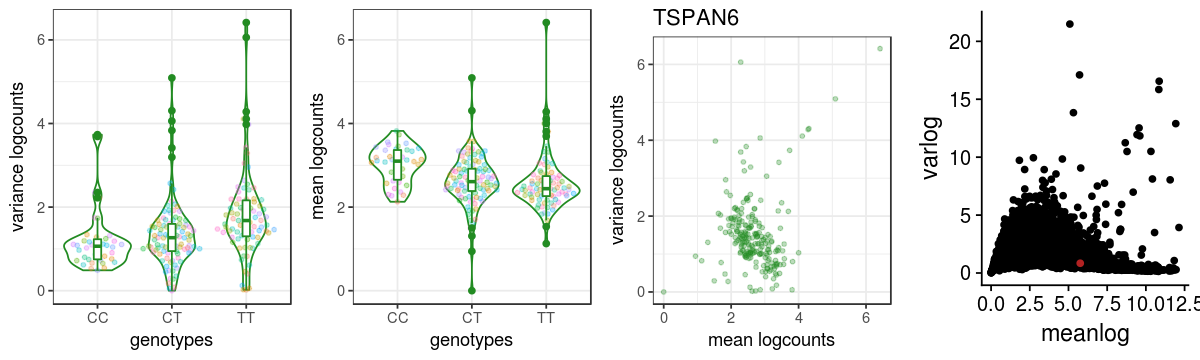

In [534]:
plot_grid(p1, p2, p3, p4, ncol = 4)

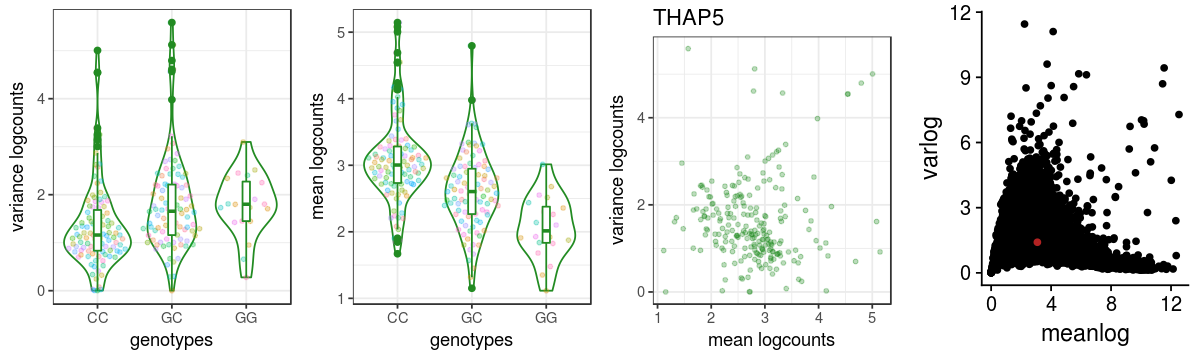

In [372]:
plot_grid(p1, p2, p3, p4, ncol = 4)

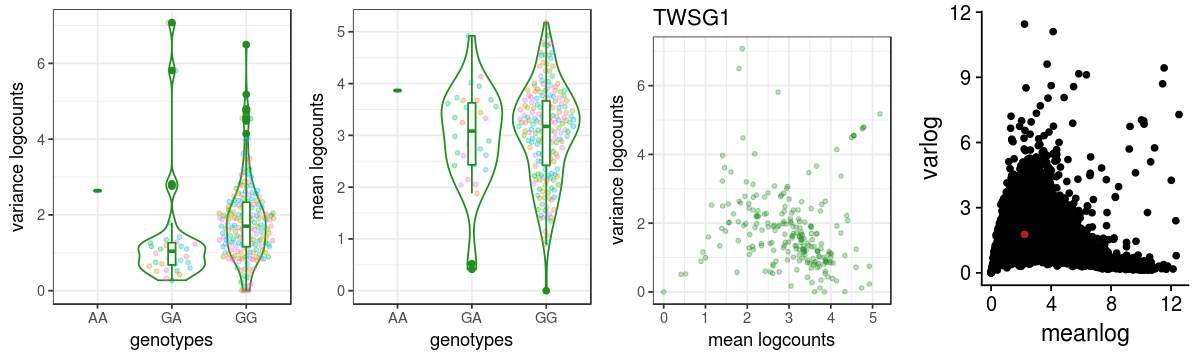

In [379]:
plot_grid(p1, p2, p3, p4, ncol = 4)

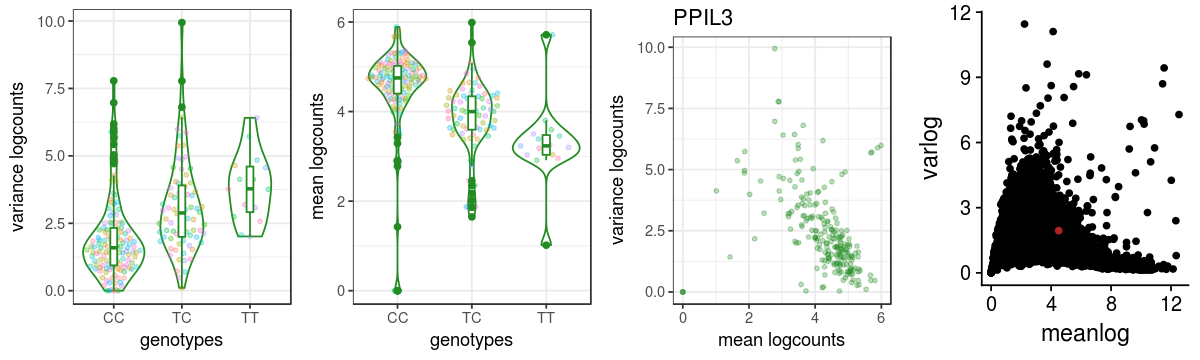

In [386]:
plot_grid(p1, p2, p3, p4, ncol = 4)

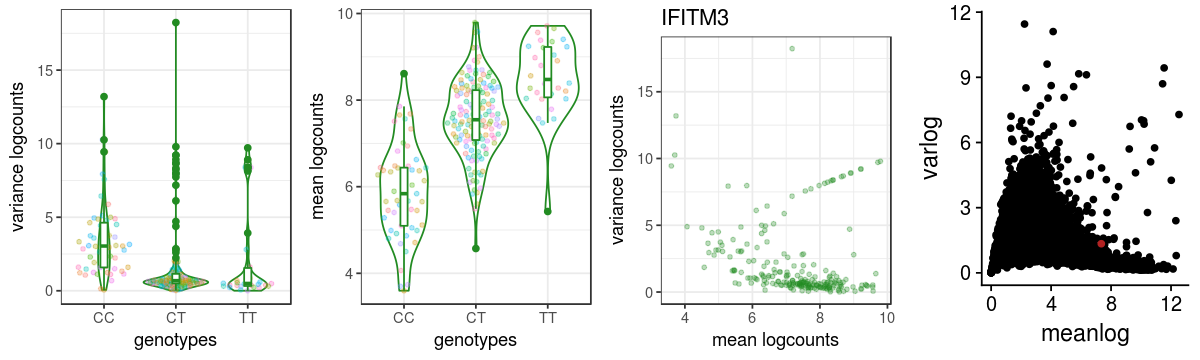

In [393]:
plot_grid(p1, p2, p3, p4, ncol = 4)

In [409]:
df.de.genes = data.frame(meanlog = rowMeans(logcounts(sce.defendo)),
                         varlog = apply(logcounts(sce.defendo),1,var),
                         genes = rownames(sce.defendo))
head(df.de.genes)

meanlog   varlog   genes                   
ENSG00000000003_TSPAN6   5.1852678 1.453192 ENSG00000000003_TSPAN6  
ENSG00000000419_DPM1     5.4275862 2.037717 ENSG00000000419_DPM1    
ENSG00000000457_SCYL3    0.7388211 1.396958 ENSG00000000457_SCYL3   
ENSG00000000460_C1orf112 2.9698817 1.635773 ENSG00000000460_C1orf112
ENSG00000001036_FUCA2    3.1865152 3.118628 ENSG00000001036_FUCA2   
ENSG00000001084_GCLC     1.6186152 2.763384 ENSG00000001084_GCLC

In [410]:
gene = "ENSG00000000003_TSPAN6"

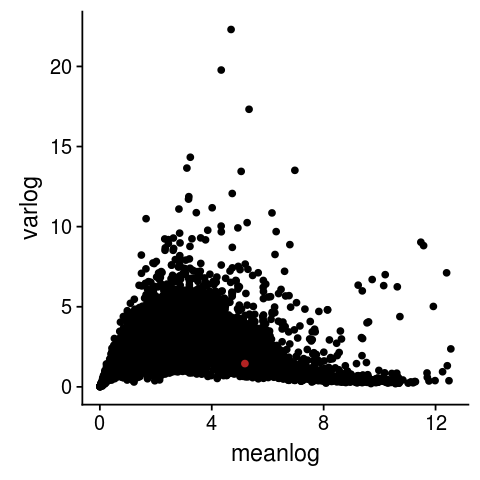

In [411]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(df.de.genes, aes(x = meanlog, y = varlog)) + geom_point() + 
    geom_point(data = df.de.genes[gene,], aes(x = meanlog, y = varlog), col = "firebrick")

In [412]:
v.defendo <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/variance/variance/defendo_pheno.txt", sep = "\t", row.names = 1)
# head(v.defendo)                

In [413]:
m.defendo <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/mean/variance/defendo_pheno.txt", sep = "\t", row.names = 1)
# head(m.defendo)                

In [428]:
df.de.expr <- df.de.expr[order(df.de.expr$qvalue),]
qtl = df.de.expr[df.de.expr$beta.var*df.de.expr$beta.mean < 0,][3,]

In [429]:
snp = qtl$snp_id
gene = qtl$feature
snp
gene
ref = qtl$ref_allele.var
alt = qtl$alt_allele.var

[1] "7_108179726_G_C"

[1] "ENSG00000177683_THAP5"

In [430]:
#genos
geno = genos[rownames(genos) == snp,]
df1 = as.data.frame(t(rbind(geno,colnames(geno))))
df1[,2] = gsub("\\.","-",df1[,2])
df1[,2] = gsub(".*-","",df1[,2])
colnames(df1) = c("dosages","donor")
df1 <- dplyr::mutate(df1, genotypes = round(as.numeric(dosages)))
df1[df1$genotypes == 0,"alleles"] <- paste0(ref,ref)
df1[df1$genotypes == 1,"alleles"] <- paste0(ref,alt)
df1[df1$genotypes == 2,"alleles"] <- paste0(alt,alt)
# head(df1)

In [431]:
df0 = data.frame(variance = matrix(t(v.defendo[gene,])), mean = matrix(t(m.defendo[gene,])), donor.expt.day = colnames(v.defendo))
df0$donor <- gsub("\\..*","",df0$donor.expt.day)
# head(df0)

In [432]:
df <- inner_join(df1, df0, by = "donor")

In [433]:
col = "coral"
p1 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(variance))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(variance), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("variance logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p2 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(mean))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(mean), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("mean logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p3 <- ggplot(df, aes(x = as.numeric(mean), y = as.numeric(variance))) + 
        geom_point(col = col, size = 1, alpha = 0.3) + 
        xlab("mean logcounts") + ylab("variance logcounts") + theme_bw() + ggtitle(gsub(".*_","",gene))
p4 <- ggplot(df.ips.genes, aes(x = meanlog, y = varlog)) + geom_point() + 
    geom_point(data = df.ips.genes[gene,], aes(x = meanlog, y = varlog), col = "firebrick")
options(repr.plot.width = 10, repr.plot.height = 3)

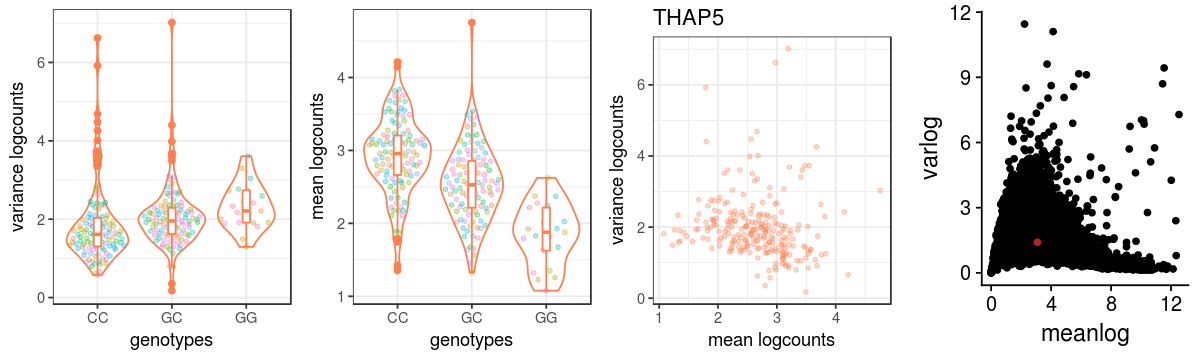

In [434]:
plot_grid(p1, p2, p3, p4, ncol = 4)

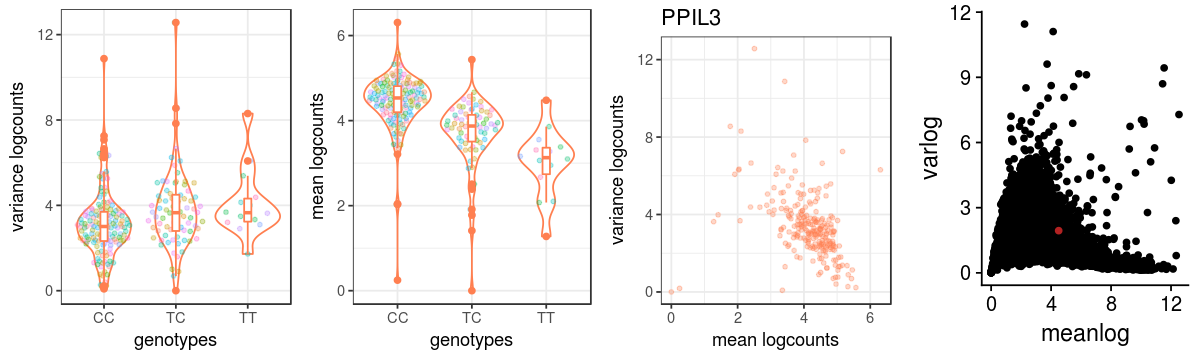

In [427]:
plot_grid(p1, p2, p3, p4, ncol = 4)

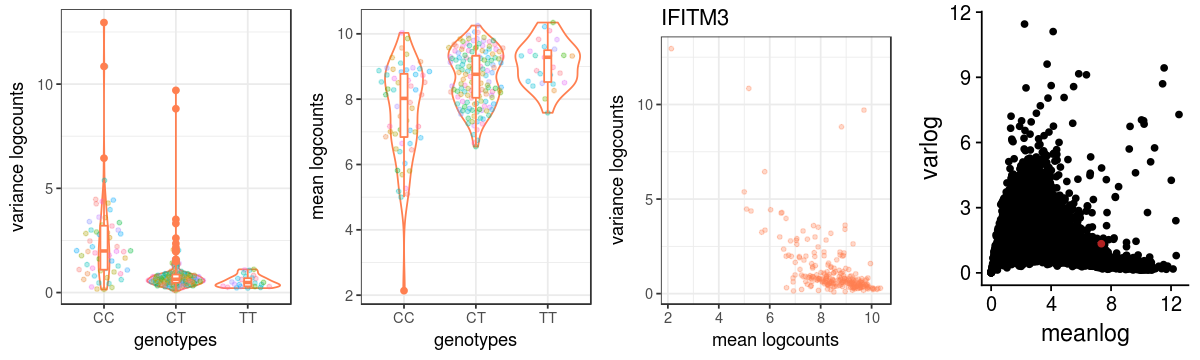

In [420]:
plot_grid(p1, p2, p3, p4, ncol = 4)

In [ ]:
## given the mean-variance relationship of log-counts it is difficult to tell whether the genetic effect we find
## are real, or driven by overall trends
## sometimes here higher mean corresponds to higher variance, sometimes to lower
## this is because we have been looking at variance and mean of logcounts
## if we looked at the variance and mean of counts - and then take the log values, the trend becomes linear
## i.e. log(var(counts)) ~ log(mean(counts))

In [ ]:
### Compare log-variance results with mean results

In [ ]:
## ips

In [734]:
res.logvar.ips.leads <- GetResults("/nfs/leia/research/stegle/acuomo/variances/logvariance_ips_leads/") 
res.logvar.ips.leads$qvalue <- qvalue(res.logvar.ips.leads$p_value)$qvalues

In [735]:
dim(res.logvar.ips.leads)

[1] 1803   11

In [736]:
df.ips.log <- inner_join(leads.ips.sign, res.logvar.ips.leads, by = c("snp_id","feature"), suffix = c(".mean",".var"))
head(df.ips.log[,c("feature","snp_id","global_corr_p_value","p_value.mean","p_value.var","beta.mean","beta.var","qvalue")])

feature                snp_id          global_corr_p_value p_value.mean
1 ENSG00000164587_RPS14  5_149826526_C_T 2.880363e-30        3.851118e-36
2 ENSG00000134809_TIMM10 11_57283988_C_T 8.853960e-23        3.147553e-30
3 ENSG00000197728_RPS26  12_56401085_G_A 8.853960e-23        9.762508e-30
4 ENSG00000214087_ARL16  17_79634162_T_G 9.364347e-23        3.835702e-33
5 ENSG00000198563_DDX39B 6_31486901_T_C  1.096676e-22        7.269794e-39
6 ENSG00000163682_RPL9   4_39446549_G_A  1.260613e-22        2.553619e-46
  p_value.var  beta.mean  beta.var   qvalue      
1 8.370267e-22 -1.0048674 -0.4358958 6.976513e-21
2 5.274472e-24 -0.9881017 -0.6563899 5.784483e-23
3 1.857583e-23 -0.8408477 -0.6230738 1.682905e-22
4 9.409287e-14 -1.0706501 -0.4547689 3.844374e-13
5 1.893389e-20 -1.1430440 -0.9071857 1.315097e-19
6 1.162179e-37 -1.4578537 -0.9786825 1.210827e-35

[1] 0.8858835

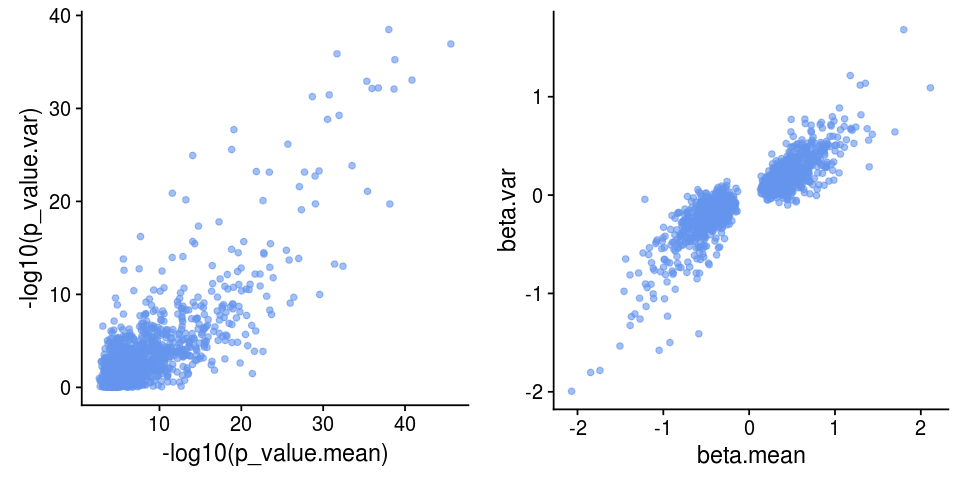

In [737]:
p1 <- ggplot(df.ips.log, aes(x = -log10(p_value.mean), y = -log10(p_value.var))) + 
    geom_point(alpha = 0.6, col = "cornflowerblue")
p2 <- ggplot(df.ips.log, aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "cornflowerblue")
options(repr.plot.width = 8, repr.plot.height = 4)
cor(df.ips.log$beta.mean, df.ips.log$beta.var)
plot_grid(p1, p2, ncol = 2)

In [738]:
## mesendo

In [739]:
res.logvar.me.leads <- GetResults("/nfs/leia/research/stegle/acuomo/variances/logvariance_mesendo_leads/") 
res.logvar.me.leads$qvalue <- qvalue(res.logvar.me.leads$p_value)$qvalues

In [740]:
dim(res.logvar.me.leads)
# head(res.logvar.me.leads)

[1] 1622   11

In [741]:
df.me.log <- inner_join(leads.mes.sign, res.logvar.me.leads, by = c("snp_id","feature"), suffix = c(".mean",".var"))
head(df.me.log[,c("feature","snp_id","global_corr_p_value","p_value.mean","p_value.var","beta.mean","beta.var","qvalue")])

feature                snp_id         global_corr_p_value p_value.mean
1 ENSG00000233927_RPS28  19_8387207_G_A 7.547212e-32        4.944358e-35
2 ENSG00000163682_RPL9   4_39446549_G_A 5.240275e-30        3.690889e-37
3 ENSG00000142089_IFITM3 11_320394_C_T  3.628888e-28        7.623224e-25
4 ENSG00000226278_PSPHP1 7_55833413_A_C 6.089332e-26        1.547255e-34
5 ENSG00000206503_HLA-A  6_29812578_C_A 2.142262e-23        4.421858e-25
6 ENSG00000130305_NSUN5  7_72717933_C_T 2.142262e-23        2.222372e-23
  p_value.var  beta.mean  beta.var   qvalue      
1 5.403828e-32 -1.3845452 -1.1904210 4.540987e-30
2 4.778891e-27 -1.4456919 -0.7761264 2.294763e-25
3 6.459270e-15 -1.1192718 -0.5058611 7.237206e-14
4 1.971102e-30  1.7971633  1.6482857 1.325097e-28
5 1.646396e-26 -1.7892350 -1.7229604 6.148945e-25
6 4.366447e-15 -0.9147762 -0.6826164 5.061030e-14

[1] 0.8693993

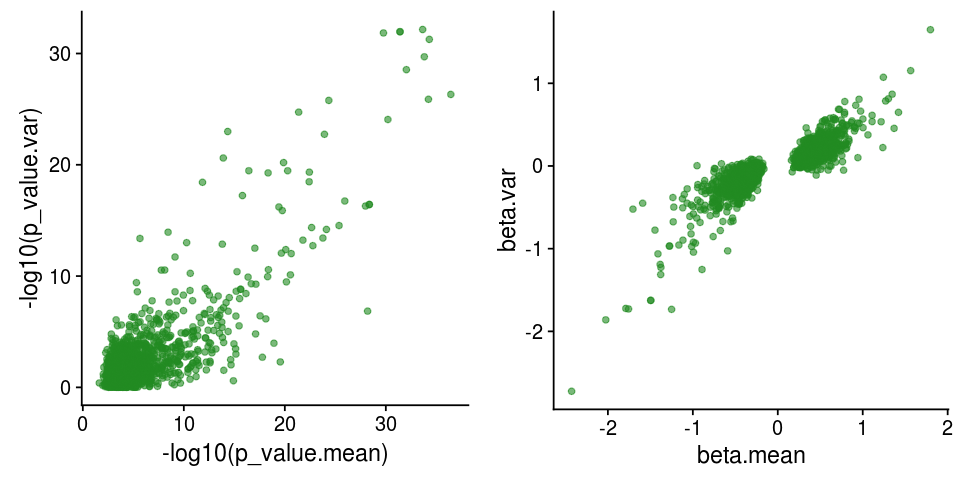

In [742]:
p1 <- ggplot(df.me.log, aes(x = -log10(p_value.mean), y = -log10(p_value.var))) + 
    geom_point(alpha = 0.6, col = "forestgreen")
p2 <- ggplot(df.me.log, aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "forestgreen")
options(repr.plot.width = 8, repr.plot.height = 4)
cor(df.me.log$beta.mean, df.me.log$beta.var)
plot_grid(p1, p2, ncol = 2)

In [743]:
## defendo

In [760]:
res.logvar.de.leads <- GetResults("/nfs/leia/research/stegle/acuomo/variances/logvariance_defendo_leads/") 
res.logvar.de.leads$qvalue <- qvalue(res.logvar.de.leads$p_value)$qvalues

In [761]:
dim(res.logvar.de.leads)
# head(res.logvar.de.leads)

[1] 1317   11

In [762]:
df.de.log <- inner_join(leads.defendo.sign, res.logvar.de.leads, by = c("snp_id","feature"), suffix = c(".mean",".var"))
head(df.de.log[,c("feature","snp_id","global_corr_p_value","p_value.mean","p_value.var","beta.mean","beta.var","qvalue")])

feature                snp_id          global_corr_p_value p_value.mean
1 ENSG00000076924_XAB2   19_7710920_G_A  5.834040e-43        2.917519e-29
2 ENSG00000226278_PSPHP1 7_55802063_T_C  2.998245e-31        3.262402e-32
3 ENSG00000132507_EIF5A  17_7207964_A_C  1.045074e-28        2.607221e-23
4 ENSG00000168653_NDUFS5 1_39465139_A_C  1.979745e-28        2.352239e-25
5 ENSG00000134809_TIMM10 11_57283988_C_T 6.671257e-25        5.732365e-21
6 ENSG00000152208_GRID2  4_93343395_C_T  8.571374e-23        2.175315e-21
  p_value.var  beta.mean  beta.var   qvalue      
1 1.298951e-22  1.2022830  1.1707727 9.570150e-22
2 3.354206e-30  1.7099543  1.7001377 3.939250e-28
3 6.806789e-16 -0.9470534 -0.4864288 2.284010e-15
4 3.430906e-12 -0.9122687 -0.4174889 8.573036e-12
5 2.390916e-16 -1.0173650 -0.5937763 8.786632e-16
6 8.632471e-19  1.0996537  0.9867574 4.407893e-18

[1] 0.8788503

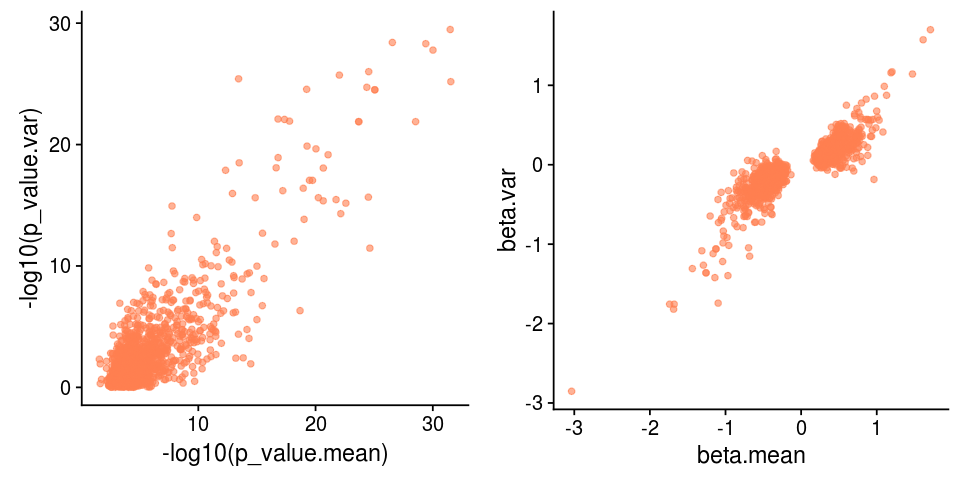

In [763]:
p1 <- ggplot(df.de.log, aes(x = -log10(p_value.mean), y = -log10(p_value.var))) + 
    geom_point(alpha = 0.6, col = "coral")
p2 <- ggplot(df.de.log, aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "coral")
options(repr.plot.width = 8, repr.plot.height = 4)
cor(df.de.log$beta.mean, df.de.log$beta.var)
plot_grid(p1, p2, ncol = 2)

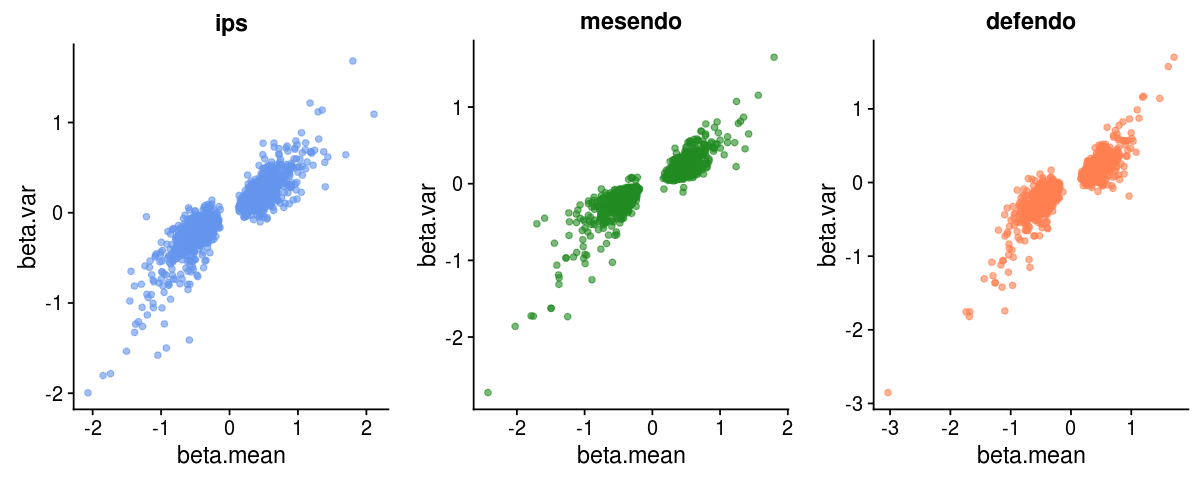

In [748]:
p1 <- ggplot(df.ips.log[df.ips.log$qvalue < 0.1,], aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "cornflowerblue") + ggtitle("ips")
p2 <- ggplot(df.me.log[df.me.log$qvalue < 0.1,], aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "forestgreen") + ggtitle("mesendo")
p3 <- ggplot(df.de.log[df.de.log$qvalue < 0.1,], aes(x = beta.mean, y = beta.var)) + 
    geom_point(alpha = 0.6, col = "coral") + ggtitle("defendo")
options(repr.plot.width = 10, repr.plot.height = 4)
plot_grid(p1, p2, p3, ncol = 3)

In [749]:
# ips
expr.ips <- logcounts(sce.ips)[rownames(sce.ips) %in% df.ips$feature,]
df.exprs.ips <- data.frame(feature = rownames(expr.ips), avg_expr = rowMeans(expr.ips))
df.ips.expr <- inner_join(df.ips.log, df.exprs.ips, by = "feature")
# mesendo
expr.me =  logcounts(sce.mesendo)[rownames(sce.mesendo) %in% df.me$feature,]
df.exprs.me <- data.frame(feature = rownames(expr.me), avg_expr = rowMeans(expr.me))
df.me.expr <- inner_join(df.me.log, df.exprs.me, by = "feature")
# defendo
expr.de =  logcounts(sce.defendo)[rownames(sce.defendo) %in% df.de$feature,]
df.exprs.de <- data.frame(feature = rownames(expr.de), avg_expr = rowMeans(expr.de))
df.de.expr <- inner_join(df.de.log, df.exprs.de, by = "feature")

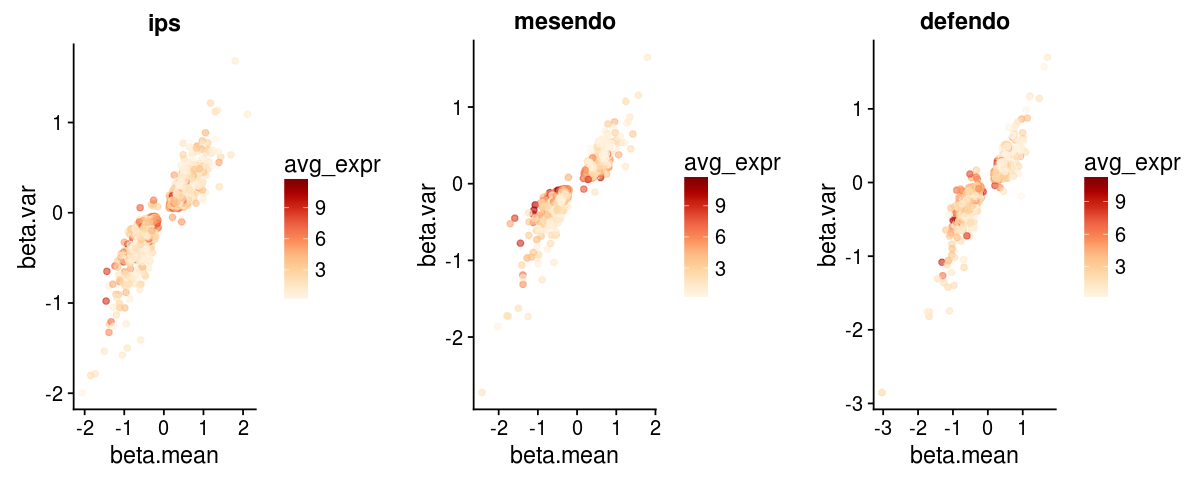

In [750]:
p1 <- ggplot(df.ips.expr[df.ips.expr$qvalue < 0.05,], 
             aes(x = beta.mean, y = beta.var, colour = avg_expr)) + 
    geom_point(alpha = 0.6) + scale_colour_gradientn(colors = brewer.pal("OrRd",n = 9)) +  ggtitle("ips")
p2 <- ggplot(df.me.expr[df.me.expr$qvalue < 0.05,], 
             aes(x = beta.mean, y = beta.var, colour = avg_expr)) + 
    geom_point(alpha = 0.6) + scale_colour_gradientn(colors = brewer.pal("OrRd",n = 9)) + ggtitle("mesendo")
p3 <- ggplot(df.de.expr[df.de.expr$qvalue < 0.05,], 
             aes(x = beta.mean, y = beta.var, colour = avg_expr)) + 
    geom_point(alpha = 0.6) + scale_colour_gradientn(colors = brewer.pal("OrRd",n = 9)) + ggtitle("defendo")
options(repr.plot.width = 10, repr.plot.height = 4)
plot_grid(p1, p2, p3, ncol = 3)

In [705]:
df.ips.genes = data.frame(logmean = log2(rowMeans(counts(sce.ips))+1),
                         logvar = log2(apply(counts(sce.ips),1,var)+1),
                         genes = rownames(sce.ips))
head(df.ips.genes)

logmean  logvar    genes                   
ENSG00000000003_TSPAN6   5.894017 10.670117 ENSG00000000003_TSPAN6  
ENSG00000000419_DPM1     6.166358 11.202698 ENSG00000000419_DPM1    
ENSG00000000457_SCYL3    1.344833  3.631518 ENSG00000000457_SCYL3   
ENSG00000000460_C1orf112 3.716477  7.396865 ENSG00000000460_C1orf112
ENSG00000001036_FUCA2    4.685753  8.620872 ENSG00000001036_FUCA2   
ENSG00000001084_GCLC     2.791754  6.106358 ENSG00000001084_GCLC

In [707]:
gene = "ENSG00000000003_TSPAN6"

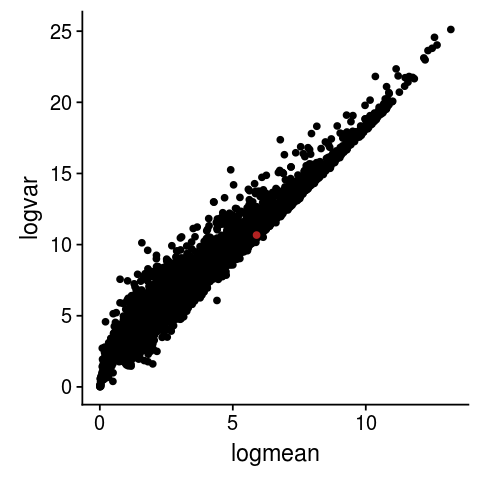

In [708]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(df.ips.genes, aes(x = logmean, y = logvar)) + geom_point() + 
    geom_point(data = df.ips.genes[gene,], aes(x = logmean, y = logvar), col = "firebrick")

In [709]:
logv.ips <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/variance/logvariance/ips_pheno.txt", sep = "\t", row.names = 1)
# head(logv.ips)                

In [719]:
logm.ips <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/variance/logmean/ips_pheno.txt", sep = "\t", row.names = 1)
# head(logm.ips)                

In [773]:
df.ips.expr <- df.ips.expr[order(df.ips.expr$qvalue),]
qtl = df.ips.expr[df.ips.expr$beta.var*df.ips.expr$beta.mean < 0,][3,]

In [774]:
# qtl

In [775]:
# qtl
snp = qtl$snp_id
gene = qtl$feature
snp
gene
ref = qtl$ref_allele.var
alt = qtl$alt_allele.var

[1] "1_1112982_C_T"

[1] "ENSG00000078808_SDF4"

In [776]:
#genos
geno = genos[rownames(genos) == snp,]
df1 = as.data.frame(t(rbind(geno,colnames(geno))))
df1[,2] = gsub("\\.","-",df1[,2])
df1[,2] = gsub(".*-","",df1[,2])
colnames(df1) = c("dosages","donor")
df1 <- dplyr::mutate(df1, genotypes = round(as.numeric(dosages)))
df1[df1$genotypes == 0,"alleles"] <- paste0(ref,ref)
df1[df1$genotypes == 1,"alleles"] <- paste0(ref,alt)
df1[df1$genotypes == 2,"alleles"] <- paste0(alt,alt)
# head(df1)

In [777]:
df0 = data.frame(variance = matrix(t(logv.ips[gene,])), mean = matrix(t(logm.ips[gene,])), donor.expt.day = colnames(logv.ips))
df0$donor <- gsub("\\..*","",df0$donor.expt.day)
# head(df0)

In [778]:
df <- inner_join(df1, df0, by = "donor")

In [779]:
col = "cornflowerblue"
p1 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(variance))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(variance), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("log-variance counts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p2 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(mean))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(mean), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("log-mean counts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p3 <- ggplot(df, aes(x = as.numeric(mean), y = as.numeric(variance))) + 
        geom_point(col = col, size = 1, alpha = 0.3) + 
        xlab("log-mean counts") + ylab("log-variance counts") + theme_bw() + ggtitle(gsub(".*_","",gene))
p4 <- ggplot(df.ips.genes, aes(x = logmean, y = logvar)) + geom_point() + 
    geom_point(data = df.ips.genes[gene,], aes(x = logmean, y = logvar), col = "firebrick")
options(repr.plot.width = 10, repr.plot.height = 3)

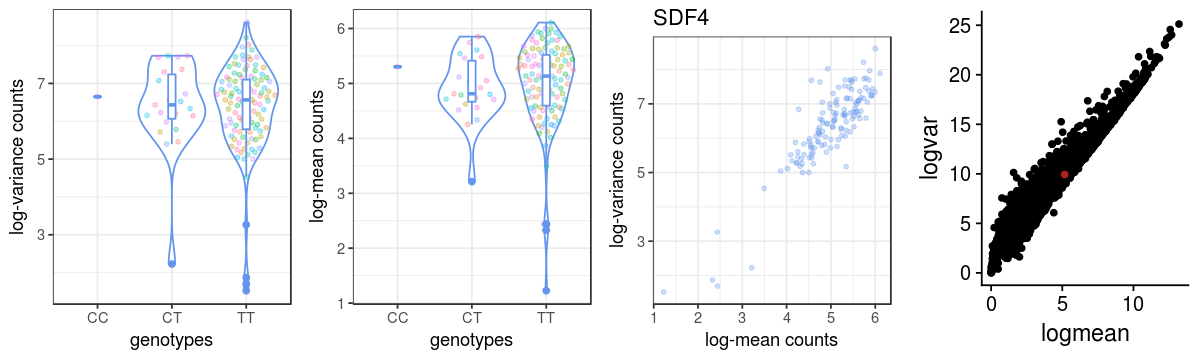

In [780]:
plot_grid(p1, p2, p3, p4, ncol = 4)

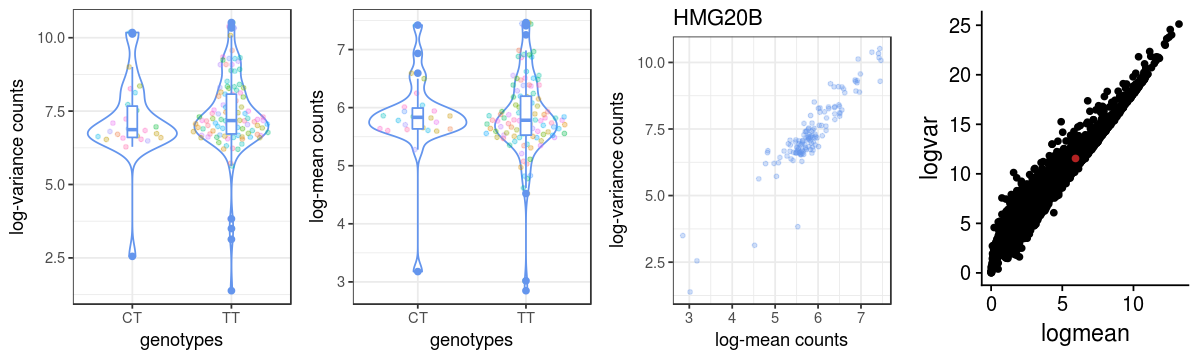

In [772]:
plot_grid(p1, p2, p3, p4, ncol = 4)

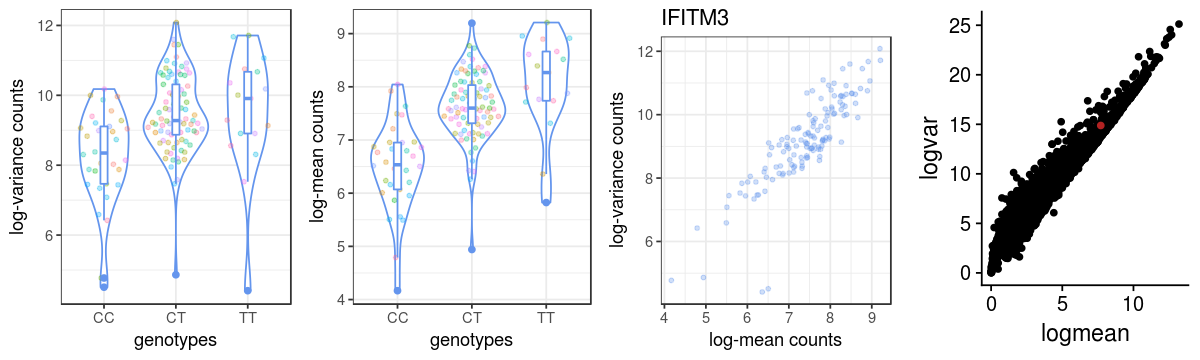

In [759]:
plot_grid(p1, p2, p3, p4, ncol = 4)

In [603]:
df.me.genes = data.frame(logmean = log2(rowMeans(counts(sce.mesendo))+1),
                         logvar = log2(apply(counts(sce.mesendo),1,var)+1),
                         genes = rownames(sce.mesendo))
head(df.me.genes)

logmean  logvar    genes                   
ENSG00000000003_TSPAN6   5.975421 11.327620 ENSG00000000003_TSPAN6  
ENSG00000000419_DPM1     6.192324 11.478216 ENSG00000000419_DPM1    
ENSG00000000457_SCYL3    1.409981  4.287808 ENSG00000000457_SCYL3   
ENSG00000000460_C1orf112 3.745087  7.655368 ENSG00000000460_C1orf112
ENSG00000001036_FUCA2    3.977462  7.953703 ENSG00000001036_FUCA2   
ENSG00000001084_GCLC     2.397650  5.962313 ENSG00000001084_GCLC

In [604]:
gene = "ENSG00000000003_TSPAN6"

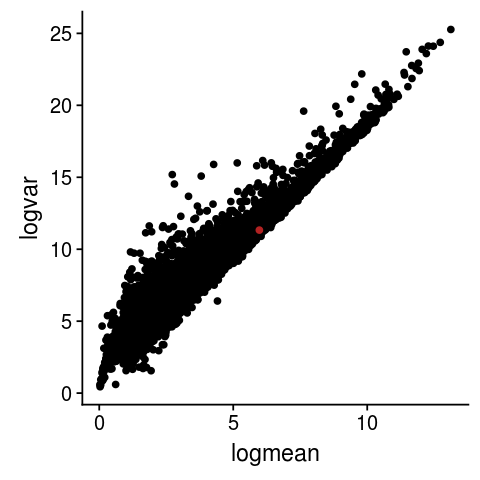

In [605]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(df.me.genes, aes(x = logmean, y = logvar)) + geom_point() + 
    geom_point(data = df.me.genes[gene,], aes(x = logmean, y = logvar), col = "firebrick")

In [606]:
logv.mesendo <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/variance/logvariance/mesendo_pheno.txt", sep = "\t", row.names = 1)
# head(logv.mesendo)                

In [689]:
df.me.expr <- df.me.expr[order(df.me.expr$qvalue),]
qtl = df.me.expr[df.me.expr$beta.var*df.me.expr$beta.mean < 0,][5,]

In [690]:
qtl

beta.mean  beta_se.mean empirical_feature_p_value.mean p_value.mean
1362 -0.3028846 0.08610031   0.01306791                     0.0004351227
     snp_id         feature                global_corr_p_value chrom.mean
1362 5_37279482_C_T ENSG00000113569_NUP155 0.07436061          5         
     pos.mean ref_allele.mean ⋯ beta.var   beta_se.var
1362 37279482 C               ⋯ 0.06998093 0.06650649 
     empirical_feature_p_value.var p_value.var chrom.var pos.var 
1362 0.5155698                     0.2926885   5         37279482
     ref_allele.var alt_allele.var qvalue     avg_expr
1362 C              T              0.07644267 3.116008

In [691]:
# qtl
snp = qtl$snp_id
gene = qtl$feature
snp
gene
ref = qtl$ref_allele.var
alt = qtl$alt_allele.var

[1] "5_37279482_C_T"

[1] "ENSG00000113569_NUP155"

In [692]:
#genos
geno = genos[rownames(genos) == snp,]
df1 = as.data.frame(t(rbind(geno,colnames(geno))))
df1[,2] = gsub("\\.","-",df1[,2])
df1[,2] = gsub(".*-","",df1[,2])
colnames(df1) = c("dosages","donor")
df1 <- dplyr::mutate(df1, genotypes = round(as.numeric(dosages)))
df1[df1$genotypes == 0,"alleles"] <- paste0(ref,ref)
df1[df1$genotypes == 1,"alleles"] <- paste0(ref,alt)
df1[df1$genotypes == 2,"alleles"] <- paste0(alt,alt)
# head(df1)

In [693]:
df0 = data.frame(variance = matrix(t(logv.mesendo[gene,])), mean = matrix(t(m.mesendo[gene,])), donor.expt.day = colnames(v.mesendo))
df0$donor <- gsub("\\..*","",df0$donor.expt.day)
# head(df0)

In [694]:
df <- inner_join(df1, df0, by = "donor")

In [695]:
col = "forestgreen"
p1 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(variance))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(variance), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("log-variance counts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p2 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(mean))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(mean), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("mean logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p3 <- ggplot(df, aes(x = as.numeric(mean), y = as.numeric(variance))) + 
        geom_point(col = col, size = 1, alpha = 0.3) + 
        xlab("mean logcounts") + ylab("log-variance counts") + theme_bw() + ggtitle(gsub(".*_","",gene))
p4 <- ggplot(df.me.genes, aes(x = logmean, y = logvar)) + geom_point() + 
    geom_point(data = df.me.genes[gene,], aes(x = logmean, y = logvar), col = "firebrick")
options(repr.plot.width = 10, repr.plot.height = 3)

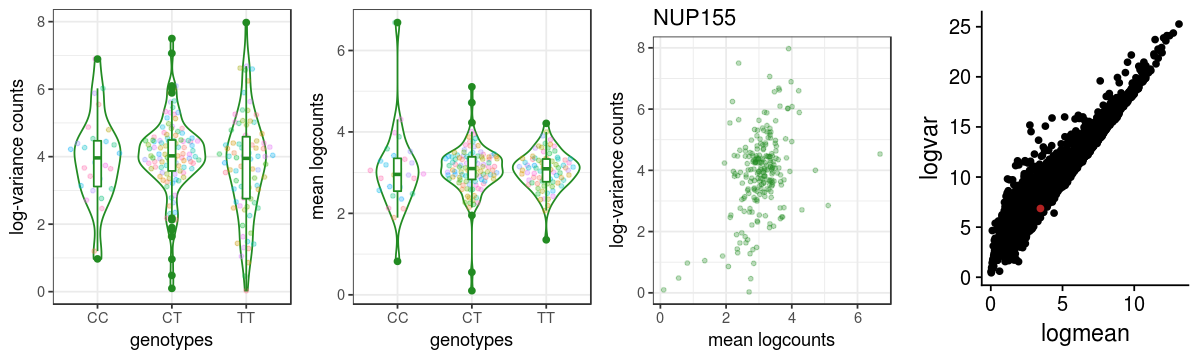

In [696]:
plot_grid(p1, p2, p3, p4, ncol = 4)

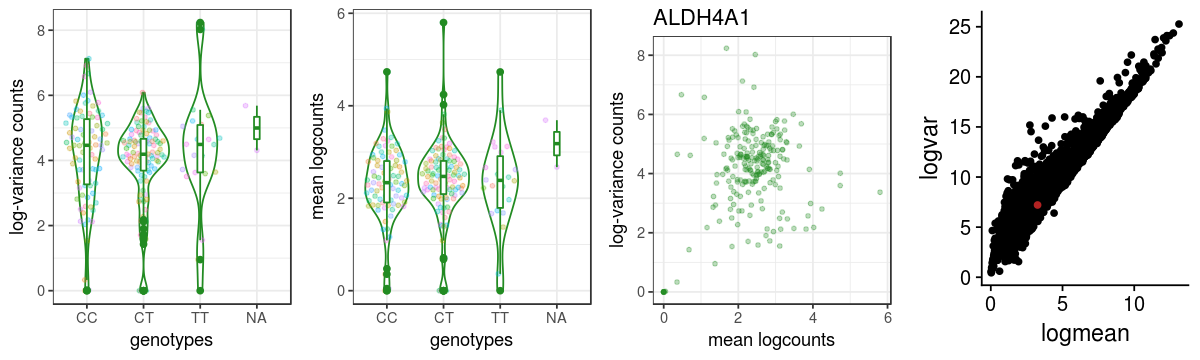

In [679]:
plot_grid(p1, p2, p3, p4, ncol = 4)

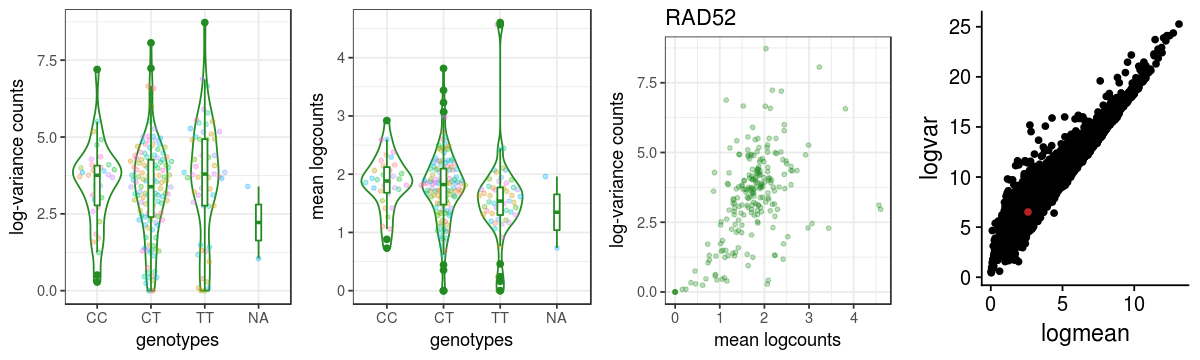

In [671]:
plot_grid(p1, p2, p3, p4, ncol = 4)

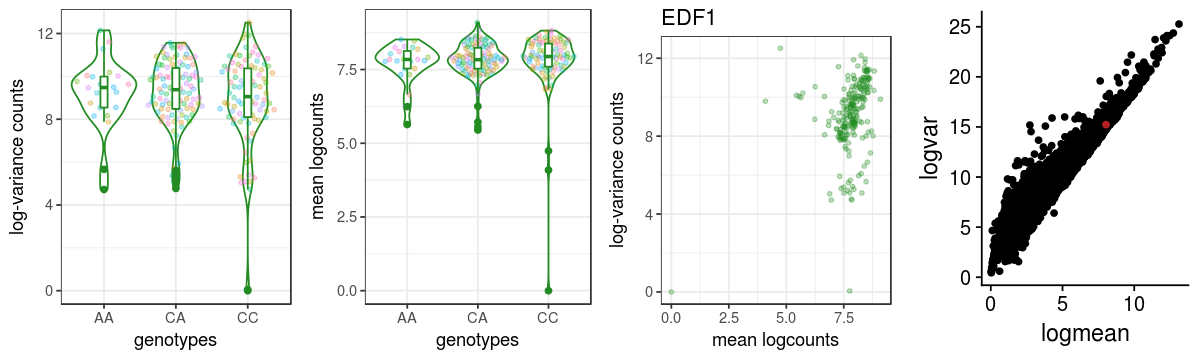

In [614]:
plot_grid(p1, p2, p3, p4, ncol = 4)

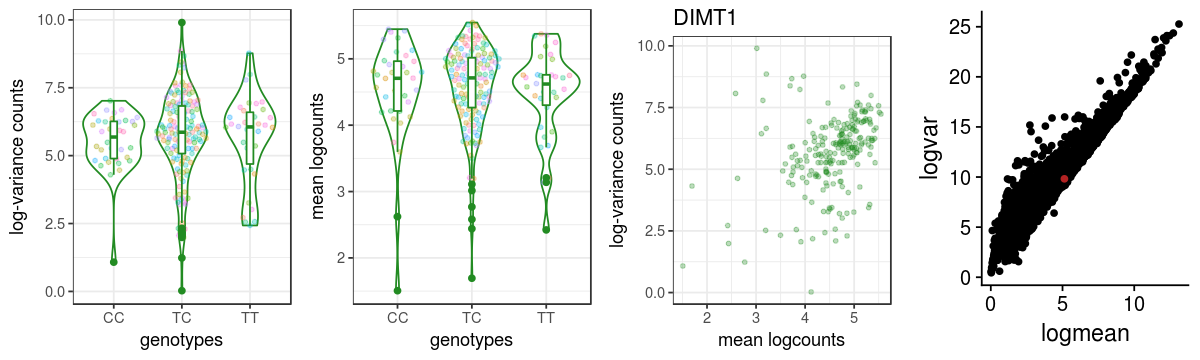

In [640]:
plot_grid(p1, p2, p3, p4, ncol = 4)

In [615]:
df.de.genes = data.frame(logmean = log2(rowMeans(counts(sce.defendo))+1),
                         logvar = log2(apply(counts(sce.defendo),1,var)+1),
                         genes = rownames(sce.defendo))
head(df.de.genes)

logmean  logvar    genes                   
ENSG00000000003_TSPAN6   5.473772 10.317120 ENSG00000000003_TSPAN6  
ENSG00000000419_DPM1     5.807909 11.028021 ENSG00000000419_DPM1    
ENSG00000000457_SCYL3    1.419646  4.281612 ENSG00000000457_SCYL3   
ENSG00000000460_C1orf112 3.468424  7.247393 ENSG00000000460_C1orf112
ENSG00000001036_FUCA2    3.944953  8.264373 ENSG00000001036_FUCA2   
ENSG00000001084_GCLC     2.581820  6.525273 ENSG00000001084_GCLC

In [616]:
gene = "ENSG00000000003_TSPAN6"

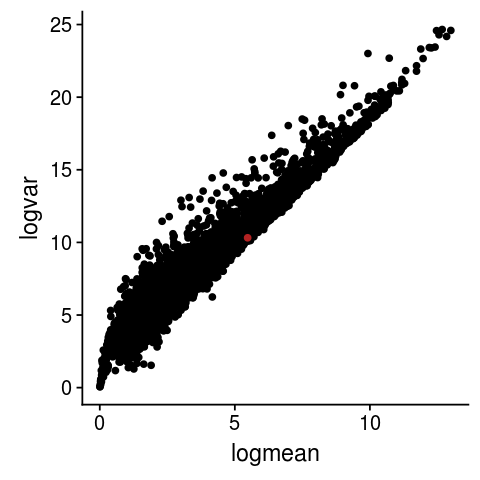

In [617]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(df.de.genes, aes(x = logmean, y = logvar)) + geom_point() + 
    geom_point(data = df.de.genes[gene,], aes(x = logmean, y = logvar), col = "firebrick")

In [618]:
logv.defendo <- read.csv("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/variance/logvariance/defendo_pheno.txt", sep = "\t", row.names = 1)
# head(logv.defendo)                

In [680]:
df.de.expr <- df.de.expr[order(df.de.expr$qvalue),]
qtl = df.de.expr[df.de.expr$beta.var*df.de.expr$beta.mean < 0,][4,]
# qtl

In [681]:
# qtl
snp = qtl$snp_id
gene = qtl$feature
snp
gene
ref = qtl$ref_allele.var
alt = qtl$alt_allele.var

[1] "4_76593147_C_A"

[1] "ENSG00000138757_G3BP2"

In [682]:
#genos
geno = genos[rownames(genos) == snp,]
df1 = as.data.frame(t(rbind(geno,colnames(geno))))
df1[,2] = gsub("\\.","-",df1[,2])
df1[,2] = gsub(".*-","",df1[,2])
colnames(df1) = c("dosages","donor")
df1 <- dplyr::mutate(df1, genotypes = round(as.numeric(dosages)))
df1[df1$genotypes == 0,"alleles"] <- paste0(ref,ref)
df1[df1$genotypes == 1,"alleles"] <- paste0(ref,alt)
df1[df1$genotypes == 2,"alleles"] <- paste0(alt,alt)
# head(df1)

In [683]:
df0 = data.frame(variance = matrix(t(logv.defendo[gene,])), mean = matrix(t(m.defendo[gene,])), donor.expt.day = colnames(v.defendo))
df0$donor <- gsub("\\..*","",df0$donor.expt.day)
# head(df0)

In [684]:
df <- inner_join(df1, df0, by = "donor")

In [685]:
col = "coral"
p1 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(variance))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(variance), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("log-variance counts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p2 <- ggplot(df, aes(x = as.factor(alleles), y = as.numeric(mean))) + 
        geom_violin(color = col) +
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(mean), colour = as.factor(donor)), 
                         alpha = 0.3, size = 1) + ylab("mean logcounts") + xlab("genotypes") +
        geom_boxplot(width = 0.1, color = col) +
        theme_bw() + theme(legend.position = "none")
p3 <- ggplot(df, aes(x = as.numeric(mean), y = as.numeric(variance))) + 
        geom_point(col = col, size = 1, alpha = 0.3) + 
        xlab("mean logcounts") + ylab("log-variance counts") + theme_bw() + ggtitle(gsub(".*_","",gene))
p4 <- ggplot(df.de.genes, aes(x = logmean, y = logvar)) + geom_point() + 
    geom_point(data = df.de.genes[gene,], aes(x = logmean, y = logvar), col = "firebrick")
options(repr.plot.width = 10, repr.plot.height = 3)

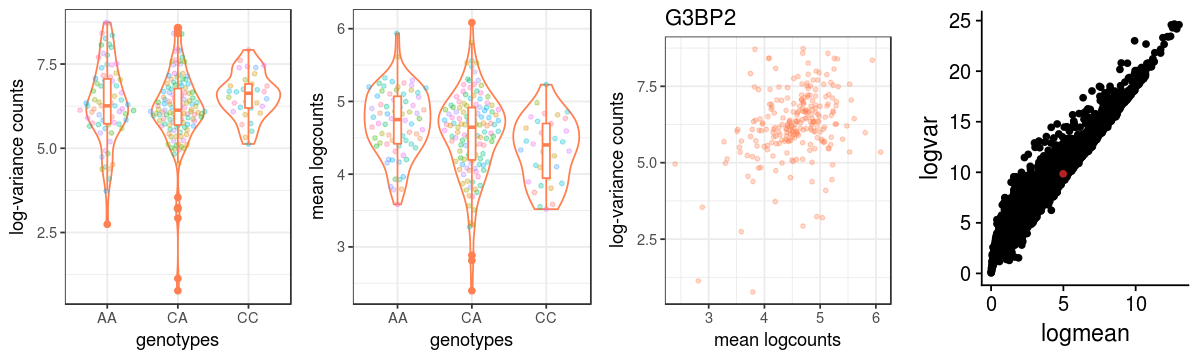

In [686]:
plot_grid(p1, p2, p3, p4, ncol = 4)

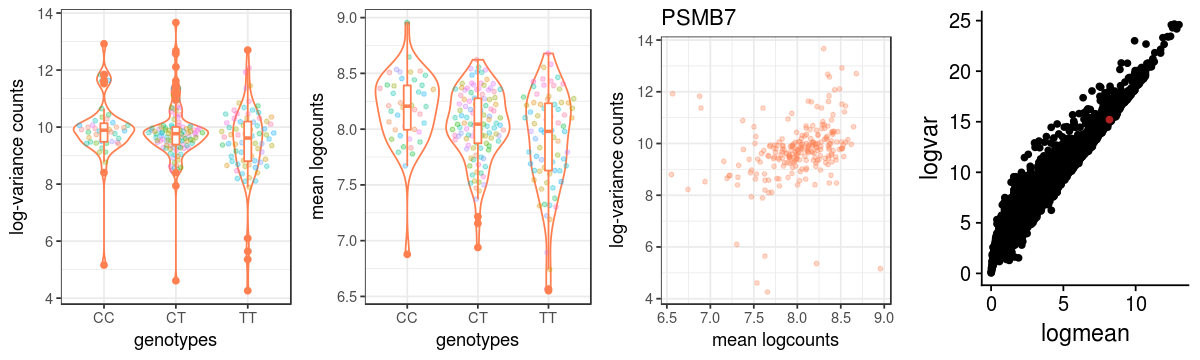

In [663]:
plot_grid(p1, p2, p3, p4, ncol = 4)

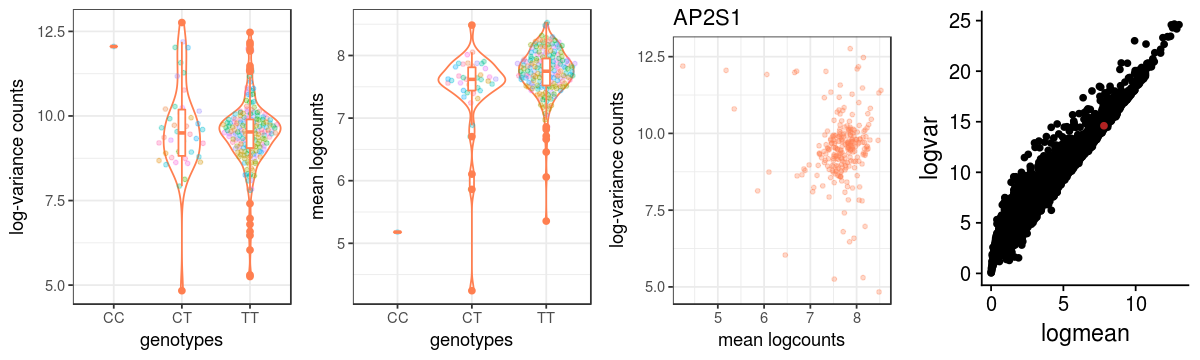

In [654]:
plot_grid(p1, p2, p3, p4, ncol = 4)

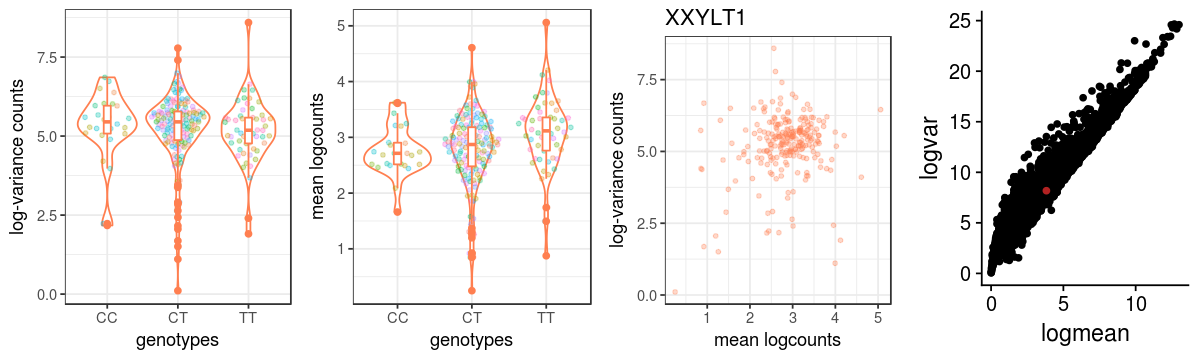

In [647]:
plot_grid(p1, p2, p3, p4, ncol = 4)